In [161]:
%pip install pandas seaborn scipy

Note: you may need to restart the kernel to use updated packages.


In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from scipy import stats
import numpy as np

pd.options.mode.copy_on_write = True

# Define the specific version order
def version_sort_key(version):
    if version.startswith('OS'):
        # Extract version number
        v = version.split('-')[1]
        # Map to a sort key that puts OS versions in desired order
        version_order = {'2.16.0': 0, '2.17.1': 1, '2.18.0': 2}
        return (0, version_order.get(v, 999))  # OS versions first
    else:
        # ES versions last
        return (1, version)  # Sort ES versions alphabetically after OS


def get_performance_summary(df, value_field = 'value'):
    results = []
    # Sort versions in the specified order
    all_versions = sorted(df['engine_version'].unique(), key=version_sort_key)
    
    # Check if we have any ES version
    es_versions = [v for v in all_versions if v.startswith('ES')]
    if not es_versions:
        print("No ES version found in the data!")
        return None, None
    
    # Track statistics for each OS version
    os_statistics = {v: {'faster': 0, 'slower': 0, 'similar': 0} for v in all_versions if v.startswith('OS')}
    
    for task in sorted(df['task'].unique()):
        task_data = df[df['task'] == task]
        
        # Calculate statistics for each version
        version_stats = {}
        for version in all_versions:
            version_data = task_data[task_data['engine_version'] == version][value_field]
            if len(version_data) > 0:
                version_stats[version] = {
                    'mean': version_data.mean(),
                    'samples': len(version_data)
                }
        
        # Skip if we don't have stats for ES version
        baseline_version = es_versions[0]
        if baseline_version not in version_stats:
            print(f"WARNING: No baseline version for {baseline_version} for task {task}")
            continue
            
        baseline_mean = version_stats[baseline_version]['mean']
        
        # Calculate statistics for all versions
        st = {}
        for version, data in version_stats.items():
            if version == baseline_version:
                st[version] = {
                    'mean': data['mean'],
                    'samples': data['samples'],
                    'is_baseline': True,
                    'percent_diff': 0,
                    'p_value': 1.0
                }
            else:
                percent_diff = ((data['mean'] - baseline_mean) / baseline_mean) * 100
                _, p_value = stats.mannwhitneyu(
                    task_data[task_data['engine_version'] == version][value_field],
                    task_data[task_data['engine_version'] == baseline_version][value_field],
                    alternative='two-sided'
                )
                st[version] = {
                    'mean': data['mean'],
                    'samples': data['samples'],
                    'is_baseline': False,
                    'percent_diff': percent_diff,
                    'p_value': p_value
                }
                
                # Update OS statistics
                if version.startswith('OS'):
                    if p_value >= 0.05:
                        os_statistics[version]['similar'] += 1
                    elif percent_diff < 0:  # Faster than ES
                        os_statistics[version]['faster'] += 1
                    else:  # Slower than ES
                        os_statistics[version]['slower'] += 1
        
        if st:  # Only append if we have statistics
            results.append({
                'task': task,
                'stats': st
            })
    
    if not results:
        print("No comparable data found!")
        return None, None

    return results, os_statistics, all_versions

def print_comparison(os_statistics):
    # Print OS vs ES statistics
    print("OS vs ES Summary:")
    print("-" * 60)
    for version in sorted(os_statistics.keys(), key=version_sort_key):
        st = os_statistics[version]
        print(f"{version}:")
        print(f"  {st['faster']} tasks significantly faster than ES")
        print(f"  {st['slower']} tasks significantly slower than ES")
        print(f"  {st['similar']} tasks not significantly different from ES")
        print()

def print_performance_summary(df, value_field = 'value'):
    print("Performance Summary Across Tasks")
    print("=" * 120)
    
    results, os_statistics, all_versions = get_performance_summary(df, value_field)
        
    # Print header
    header = ['Task']
    for version in all_versions:
        header.append(version)
    
    # Calculate column widths
    task_width = 65
    version_width = 32
    
    # Print header
    print(f"{header[0]:<{task_width}}", end='')
    for version in all_versions:
        print(f"{version:<{version_width}}", end='')
    print()
    print("-" * (task_width + version_width * len(all_versions)))
    
    # Print results
    for r in results:
        print(f"{r['task']:<{task_width}}", end='')
        for version in all_versions:
            if version in r['stats']:
                st = r['stats'][version]
                if st['is_baseline']:
                    cell = f"{st['mean']:.3f}ms (baseline)"
                else:
                    if st['p_value'] < 0.05:
                        cell = f"{st['mean']:.3f}ms ({st['percent_diff']:.1f}%, p={st['p_value']:.2f})"
                    else:
                        cell = f"{st['mean']:.3f}ms (similar, p={st['p_value']:.2f})"
            else:
                cell = "N/A"
            print(f"{cell:<{version_width}}", end='')
        print()
    
    print("\nNote: Percentages show how much faster/slower each version is compared to ES (baseline)")
    print("      'similar' means the difference is not statistically significant (p>=0.05)")
    print("      'baseline' indicates the ES version used for comparison")
    print("      'n' shows the number of samples for each version")
    print()

    print_comparison(os_statistics)

    
def create_boxplots(df, value_field='value (milliseconds)', use_percentile=None):
    tasks = df['task'].unique()
    n_tasks = len(tasks)
    
    # Calculate rows needed - 2 rows per task when using percentiles
    n_task_columns = 3
    n_rows = (n_tasks - 1) // n_task_columns + 1
    if use_percentile:
        n_rows *= 2
    
    def version_sort_key(version):
        if version.startswith('OS'):
            v = version.split('-')[1]
            version_order = {'2.16.0': 0, '2.17.1': 1, '2.18.0': 2}
            return (0, version_order.get(v, 999))
        else:
            return (1, version)
    
    # Sort engine versions consistently
    engine_versions = sorted(df['engine_version'].unique(), key=version_sort_key)
    
    # Color mapping
    color_map = {}
    os_versions = [v for v in engine_versions if v.startswith('OS')]
    for idx, version in enumerate(engine_versions):
        if version.startswith('ES'):
            color_map[version] = '#ff6b6b'  # Red for ES
        else:
            os_idx = os_versions.index(version)
            color_map[version] = plt.cm.Blues(0.5 + os_idx * 0.2)
    
    # Create subplot grid
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_task_columns, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.reshape(n_rows, n_task_columns)
    
    for task_idx, task in enumerate(sorted(tasks)):
        # Calculate position in the grid
        col = task_idx % n_task_columns
        base_row = (task_idx // n_task_columns) * (2 if use_percentile else 1)
        
        task_data = df[df['task'] == task]
        
        if use_percentile:
            # Calculate percentiles
            task_stats = []
            for version in engine_versions:
                version_data = task_data[task_data['engine_version'] == version]
                if not version_data.empty:
                    p50 = np.percentile(version_data[value_field], 50)
                    p90 = np.percentile(version_data[value_field], 90)
                    task_stats.append({
                        'engine_version': version,
                        'p50': p50,
                        'p90': p90
                    })
            
            # Create a DataFrame for the percentile plot
            stats_df = pd.DataFrame(task_stats)
            
            # Plot percentiles
            ax_percentile = axes[base_row, col]
            width = 0.35
            x = np.arange(len(engine_versions))
            
            ax_percentile.bar(x - width/2, stats_df['p50'], width, label='P50', 
                            color=[color_map[v] for v in engine_versions], alpha=0.5)
            ax_percentile.bar(x + width/2, stats_df['p90'], width, label='P90',
                            color=[color_map[v] for v in engine_versions], alpha=1.0)
            
            ax_percentile.set_xticks(x)
            ax_percentile.set_xticklabels(engine_versions, rotation=45)
            if task_idx == 0:  # Only show legend for first plot
                ax_percentile.legend()
            
            # Customize percentile plot
            ax_percentile.tick_params(axis='x', rotation=45)
            ax_percentile.set_xlabel('')
            ax_percentile.set_title(f'{task} - Percentiles')
            ax_percentile.set_ylabel('Time (ms) - P50/P90')
            ax_percentile.grid(axis='y', linestyle='--', alpha=0.3)
            
            # Plot boxplot directly below
            ax_boxplot = axes[base_row + 1, col]
            
            # Convert engine_version to categorical with desired order
            task_data['engine_version'] = pd.Categorical(
                task_data['engine_version'],
                categories=engine_versions,
                ordered=True
            )
            
            # Create box plot
            sns.boxplot(data=task_data, 
                       x='engine_version', 
                       y=value_field,
                       hue='engine_version',
                       palette=color_map,
                       legend=False,
                       whis=(10, 90),  # Set whiskers to 10th and 90th percentiles
                       ax=ax_boxplot)
            
            # Customize boxplot
            ax_boxplot.tick_params(axis='x', rotation=45)
            ax_boxplot.set_xlabel('')
            ax_boxplot.set_title(f'{task} - Distribution')
            ax_boxplot.set_ylabel('Time (ms)')
            ax_boxplot.grid(axis='y', linestyle='--', alpha=0.3)
            
        else:
            # Single boxplot when not using percentiles
            ax = axes[base_row, col]
            task_data['engine_version'] = pd.Categorical(
                task_data['engine_version'],
                categories=engine_versions,
                ordered=True
            )
            
            sns.boxplot(data=task_data, 
                       x='engine_version', 
                       y=value_field,
                       hue='engine_version',
                       palette=color_map,
                       legend=False,
                       whis=(10, 90),
                       ax=ax)
            
            # Customize plot
            ax.tick_params(axis='x', rotation=45)
            ax.set_xlabel('')
            ax.set_title(f'{task}')
            ax.set_ylabel('Time (ms)')
            ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Remove extra subplots
    for row in range(n_rows):
        for col in range(n_task_columns):
            if row >= (n_tasks * 2 if use_percentile else n_tasks):
                fig.delaxes(axes[row, col])
            elif use_percentile and row % 2 == 0 and col >= ((n_tasks - row//2 * n_task_columns - 1) // 1 + 1):
                fig.delaxes(axes[row, col])
                fig.delaxes(axes[row + 1, col])
    
    plt.tight_layout()
    return fig

def analyze_performance(df, value_field='value', use_percentile=True):
    """
    Analyze performance with option to use percentile visualization
    
    Args:
        df: DataFrame with performance data
        value_field: Column name containing the values to analyze
        use_percentile: If True, show P50/P90 bars instead of boxplots
    """
    print_performance_summary(df, value_field)
    fig = create_boxplots(df, value_field, use_percentile)
    plt.show()
    
def load_and_process_csvs(directory_path):
    # Get all CSV files in the directory
    csv_files = glob.glob(directory_path)
    
    # Read and concatenate all CSV files
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        dfs.append(df)
    
    df = pd.concat(dfs, ignore_index=True)

    # Remove OS 2.17.0 because we have 2.17.1
    df = df[df['meta.tag_cluster-version'] != '2.17.0']
    # Remove ES 8.15.0 because we have 8.15.4
    df = df[df['meta.tag_cluster-version'] != '8.15.0']

    # Only consider big5, nyc_taxis, pmc, and noaa
    # vectorsearch requires splitting into subtypes, and noaa_semantic_search cannot be compared for ES runs
    df = df[df['workload'] != 'vectorsearch']
    df = df[df['workload'] != 'noaa_semantic_search']
    
    # Extract engine type and version
    df['engine'] = df['meta.tag_engine-type']
    df['version'] = df['meta.tag_cluster-version']
    # Combine engine and version for display
    df['engine_version'] = df['engine'] + '-' + df['version']

    df['task'] = df['operation']
    return df

def filter_by_workload(df, workload):
    # First filter by workload
    res = df[df['workload'] == workload].copy()
    
    # Create a combined workload-operation identifier
    res['task'] = res['workload'] + ' / ' + res['task']
    
    return res

In [163]:
df = load_and_process_csvs("opensearch_data_2024-11-30_2024-12-18.csv")

In [164]:
def filter_recent_data(df, start_date='2024-12-01'):
    """
    Filter DataFrame to only include rows after a specific date.
    Handles Unix timestamps in milliseconds.
    
    Args:
        df: DataFrame containing performance data with Unix timestamps in milliseconds
        start_date: Start date in 'YYYY-MM-DD' format (default: '2024-12-01')
    
    Returns:
        DataFrame containing only rows after the start date
    """
    # Convert start_date to Unix timestamp in milliseconds
    start_timestamp = int(pd.to_datetime(start_date).timestamp() * 1000)

    timestamp_key = 'Timestamp (unix epoch)'
    
    # Filter the data
    filtered_df = df[df[timestamp_key] >= start_timestamp].copy()
    
    # Print summary of filtering
    total_rows = len(df)
    filtered_rows = len(filtered_df)
    removed_rows = total_rows - filtered_rows
    
    # Convert some example timestamps for verification
    if not filtered_df.empty:
        min_time = pd.to_datetime(filtered_df[timestamp_key].min(), unit='ms')
        max_time = pd.to_datetime(filtered_df[timestamp_key].max(), unit='ms')
        print(f"\nFiltering Summary:")
        print(f"Start date: {start_date}")
        print(f"Date range in filtered data: {min_time} to {max_time}")
        print(f"Total rows: {total_rows:,}")
        print(f"Rows after {start_date}: {filtered_rows:,}")
        print(f"Rows removed: {removed_rows:,} ({removed_rows/total_rows*100:.1f}%)")
    else:
        print(f"\nNo data found after {start_date}")
    
    return filtered_df

In [ ]:
data_df = filter_recent_data(df, '2024-12-05')
df = data_df


Filtering Summary:
Start date: 2024-11-10
Date range in filtered data: 2024-11-10 00:22:58.053000 to 2024-12-10 14:39:07.370000
Total rows: 6,318,794
Rows after 2024-11-10: 6,318,794
Rows removed: 0 (0.0%)


In [166]:
def print_sample_counts(df):
    """
    Print a table showing sample counts for each workload/operation pair across versions.
    """
    # Get unique versions ordered by type (OS first, then ES)
    versions = sorted(df['engine_version'].unique(), key=lambda x: ('ES' in x, x))
    
    # Create a dictionary to store the counts
    counts = {}
    
    # Collect counts for each workload/operation pair
    for workload in sorted(df['workload'].unique()):
        workload_data = df[df['workload'] == workload]
        
        for operation in sorted(workload_data['operation'].unique()):
            key = f"{workload} / {operation}"
            counts[key] = {}
            
            op_data = workload_data[workload_data['operation'] == operation]
            
            for version in versions:
                version_count = len(op_data[op_data['engine_version'] == version])
                counts[key][version] = version_count
    
    # Calculate column widths
    task_width = max(len(task) for task in counts.keys()) + 2
    version_width = max(len(version) for version in versions) + 2
    
    # Print header
    print("\nSample Counts Per Version")
    print("=" * (task_width + version_width * len(versions)))
    
    # Print version headers
    print(f"{'Task':<{task_width}}", end='')
    for version in versions:
        print(f"{version:>{version_width}}", end='')
    print()
    print("-" * (task_width + version_width * len(versions)))
    
    # Print counts
    for task in sorted(counts.keys()):
        print(f"{task:<{task_width}}", end='')
        for version in versions:
            count = counts[task][version]
            if count == 0:
                print(f"{'':>{version_width}}", end='')
            else:
                print(f"{count:>{version_width}}", end='')
        print()
    
    # Print summary
    print("\nSummary:")
    print("-" * 40)
    for version in versions:
        total = sum(counts[task][version] for task in counts.keys())
        print(f"{version}: {total:,} total samples")
    
    return counts

print_sample_counts(df)


Sample Counts Per Version
Task                                                               OS-2.16.0  OS-2.17.1  OS-2.18.0  ES-8.15.4
-------------------------------------------------------------------------------------------------------------
big5 / asc_sort_timestamp                                              30900      21600      24000      24000
big5 / asc_sort_timestamp_can_match_shortcut                           30900      21600      24000      24000
big5 / asc_sort_timestamp_no_can_match_shortcut                        30900      21600      24000      24000
big5 / asc_sort_with_after_timestamp                                   30900      21600      24000      24000
big5 / cardinality-agg-high                                            30600      21600      24000      24000
big5 / cardinality-agg-low                                             30600      21600      24000      24000
big5 / composite-date_histogram-daily                                  30900      21600      

{'big5 / asc_sort_timestamp': {'OS-2.16.0': 30900,
  'OS-2.17.1': 21600,
  'OS-2.18.0': 24000,
  'ES-8.15.4': 24000},
 'big5 / asc_sort_timestamp_can_match_shortcut': {'OS-2.16.0': 30900,
  'OS-2.17.1': 21600,
  'OS-2.18.0': 24000,
  'ES-8.15.4': 24000},
 'big5 / asc_sort_timestamp_no_can_match_shortcut': {'OS-2.16.0': 30900,
  'OS-2.17.1': 21600,
  'OS-2.18.0': 24000,
  'ES-8.15.4': 24000},
 'big5 / asc_sort_with_after_timestamp': {'OS-2.16.0': 30900,
  'OS-2.17.1': 21600,
  'OS-2.18.0': 24000,
  'ES-8.15.4': 24000},
 'big5 / cardinality-agg-high': {'OS-2.16.0': 30600,
  'OS-2.17.1': 21600,
  'OS-2.18.0': 24000,
  'ES-8.15.4': 24000},
 'big5 / cardinality-agg-low': {'OS-2.16.0': 30600,
  'OS-2.17.1': 21600,
  'OS-2.18.0': 24000,
  'ES-8.15.4': 24000},
 'big5 / composite-date_histogram-daily': {'OS-2.16.0': 30900,
  'OS-2.17.1': 21600,
  'OS-2.18.0': 24000,
  'ES-8.15.4': 24000},
 'big5 / composite-terms': {'OS-2.16.0': 30900,
  'OS-2.17.1': 21600,
  'OS-2.18.0': 24000,
  'ES-8.15.4': 

## Check if the values follow a normal distributions (they don't)

In [ ]:
def check_normality_all_tasks(df, value_field = 'value'):
    results = []
    
    # Get unique workloads and tasks
    workload_tasks = df.groupby(['workload', 'task']).size().reset_index()[['workload', 'task']]
    
    for _, row in workload_tasks.iterrows():
        workload = row['workload']
        task = row['task']
        
        # Filter data for this workload/task
        task_df = df[(df['workload'] == workload) & (df['task'] == task)]
        
        # Check for each engine version
        for version in sorted(task_df['engine_version'].unique()):
            version_data = task_df[task_df['engine_version'] == version][value_field]
            if len(version_data) >= 8:  # normaltest requires at least 8 samples
                _, p_value = stats.normaltest(version_data)
                
                results.append({
                    'workload': workload,
                    'task': task,
                    'engine_version': version,
                    'n_samples': len(version_data),
                    'p_value': p_value,
                    'is_normal': p_value >= 0.05
                })
            else:
                results.append({
                    'workload': workload,
                    'task': task,
                    'engine_version': version,
                    'n_samples': len(version_data),
                    'p_value': None,
                    'is_normal': None
                })
    
    # Convert to DataFrame for easier viewing
    results_df = pd.DataFrame(results)
    
    # Count how many are normal vs non-normal
    total_tests = len(results_df[results_df['p_value'].notna()])
    normal_count = len(results_df[results_df['is_normal'] == True])
    
    print(f"\nSummary:")
    print(f"Total tests performed: {total_tests}")
    print(f"Normal distributions: {normal_count}")
    print(f"Non-normal distributions: {total_tests - normal_count}")
    print(f"Percentage normal: {(normal_count/total_tests*100):.1f}%")
    
    # Print detailed results
    print("\nDetailed Results:")
    pd.set_option('display.max_rows', None)
    return results_df

# Run the analysis
normality_results = check_normality_all_tasks(df, 'value')
print(normality_results)


Summary:
Total tests performed: 312
Normal distributions: 0
Non-normal distributions: 312
Percentage normal: 0.0%

Detailed Results:
      workload                                               task  \
0         big5                                 asc_sort_timestamp   
1         big5                                 asc_sort_timestamp   
2         big5                                 asc_sort_timestamp   
3         big5                                 asc_sort_timestamp   
4         big5              asc_sort_timestamp_can_match_shortcut   
5         big5              asc_sort_timestamp_can_match_shortcut   
6         big5              asc_sort_timestamp_can_match_shortcut   
7         big5              asc_sort_timestamp_can_match_shortcut   
8         big5           asc_sort_timestamp_no_can_match_shortcut   
9         big5           asc_sort_timestamp_no_can_match_shortcut   
10        big5           asc_sort_timestamp_no_can_match_shortcut   
11        big5           asc_sort_time

# Workloads results

In [ ]:
ddf = df.copy()
ddf["task"] = ddf["workload"] + " / " + ddf["operation"]
_, os_statistics, _ = get_performance_summary(ddf, 'value')
print_comparison(os_statistics)

OS vs ES Summary:
------------------------------------------------------------
OS-2.16.0:
  33 tasks significantly faster than ES
  44 tasks significantly slower than ES
  1 tasks not significantly different from ES

OS-2.17.1:
  27 tasks significantly faster than ES
  51 tasks significantly slower than ES
  0 tasks not significantly different from ES

OS-2.18.0:
  27 tasks significantly faster than ES
  51 tasks significantly slower than ES
  0 tasks not significantly different from ES



# big5
Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
big5 / asc_sort_timestamp                                        4.890ms (-78.6%, p=0.00)        4.997ms (-78.1%, p=0.00)        5.038ms (-78.0%, p=0.00)        22.854ms (baseline)             
big5 / asc_sort_timestamp_can_match_shortcut                     4.938ms (-73.8%, p=0.00)        5.062ms (-73.1%, p=0.00)        5.253ms (-72.1%, p=0.00)        18.839ms (baseline)             
big5 / asc_sort_timestamp_no_can_match_shortcut                  4.946ms (-73.8%, p=0.00)        5.085ms (-73.0%, p=0.00)        5.256ms (-72.1%, p=0.00)        18.856ms (baseline)    

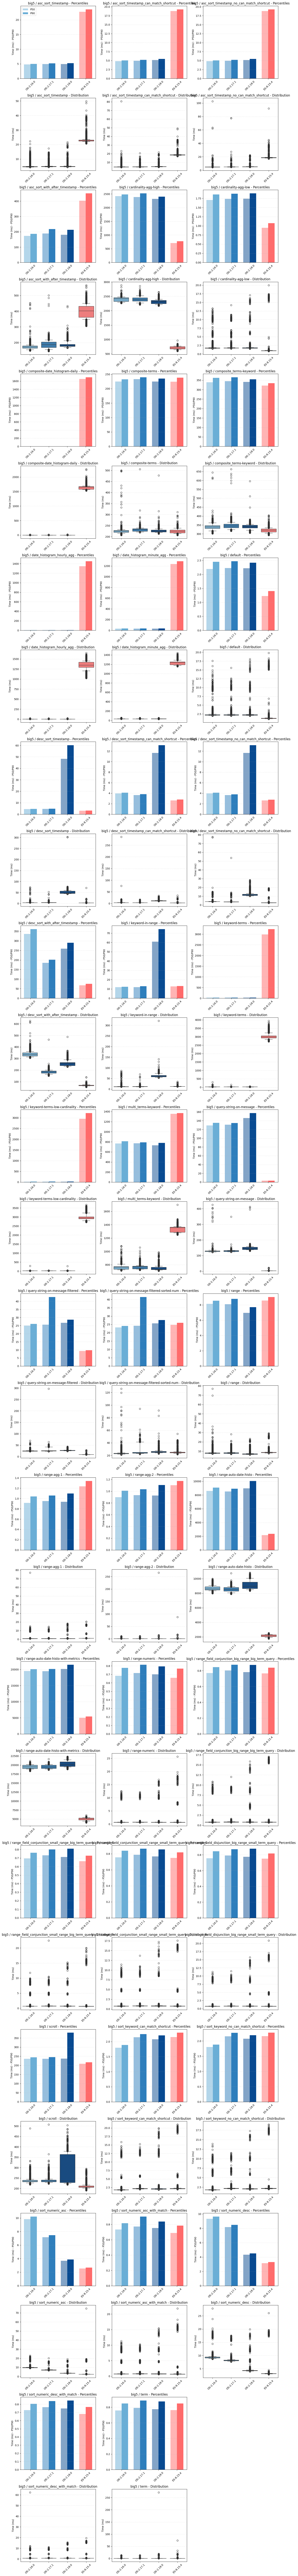



# nyc_taxis
Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
nyc_taxis / asc_sort_tip_amount                                  2.898ms (-100.0%, p=0.00)       2.881ms (-100.0%, p=0.00)       3.042ms (-99.9%, p=0.00)        6080.665ms (baseline)           
nyc_taxis / autohisto_agg                                        3.315ms (-98.8%, p=0.00)        3.332ms (-98.8%, p=0.00)        3.594ms (-98.7%, p=0.00)        269.560ms (baseline)            
nyc_taxis / date_histogram_agg                                   3.235ms (-10.7%, p=0.00)        3.261ms (-10.0%, p=0.00)        3.534ms (-2.5%, p=0.00)         3.624ms (baselin

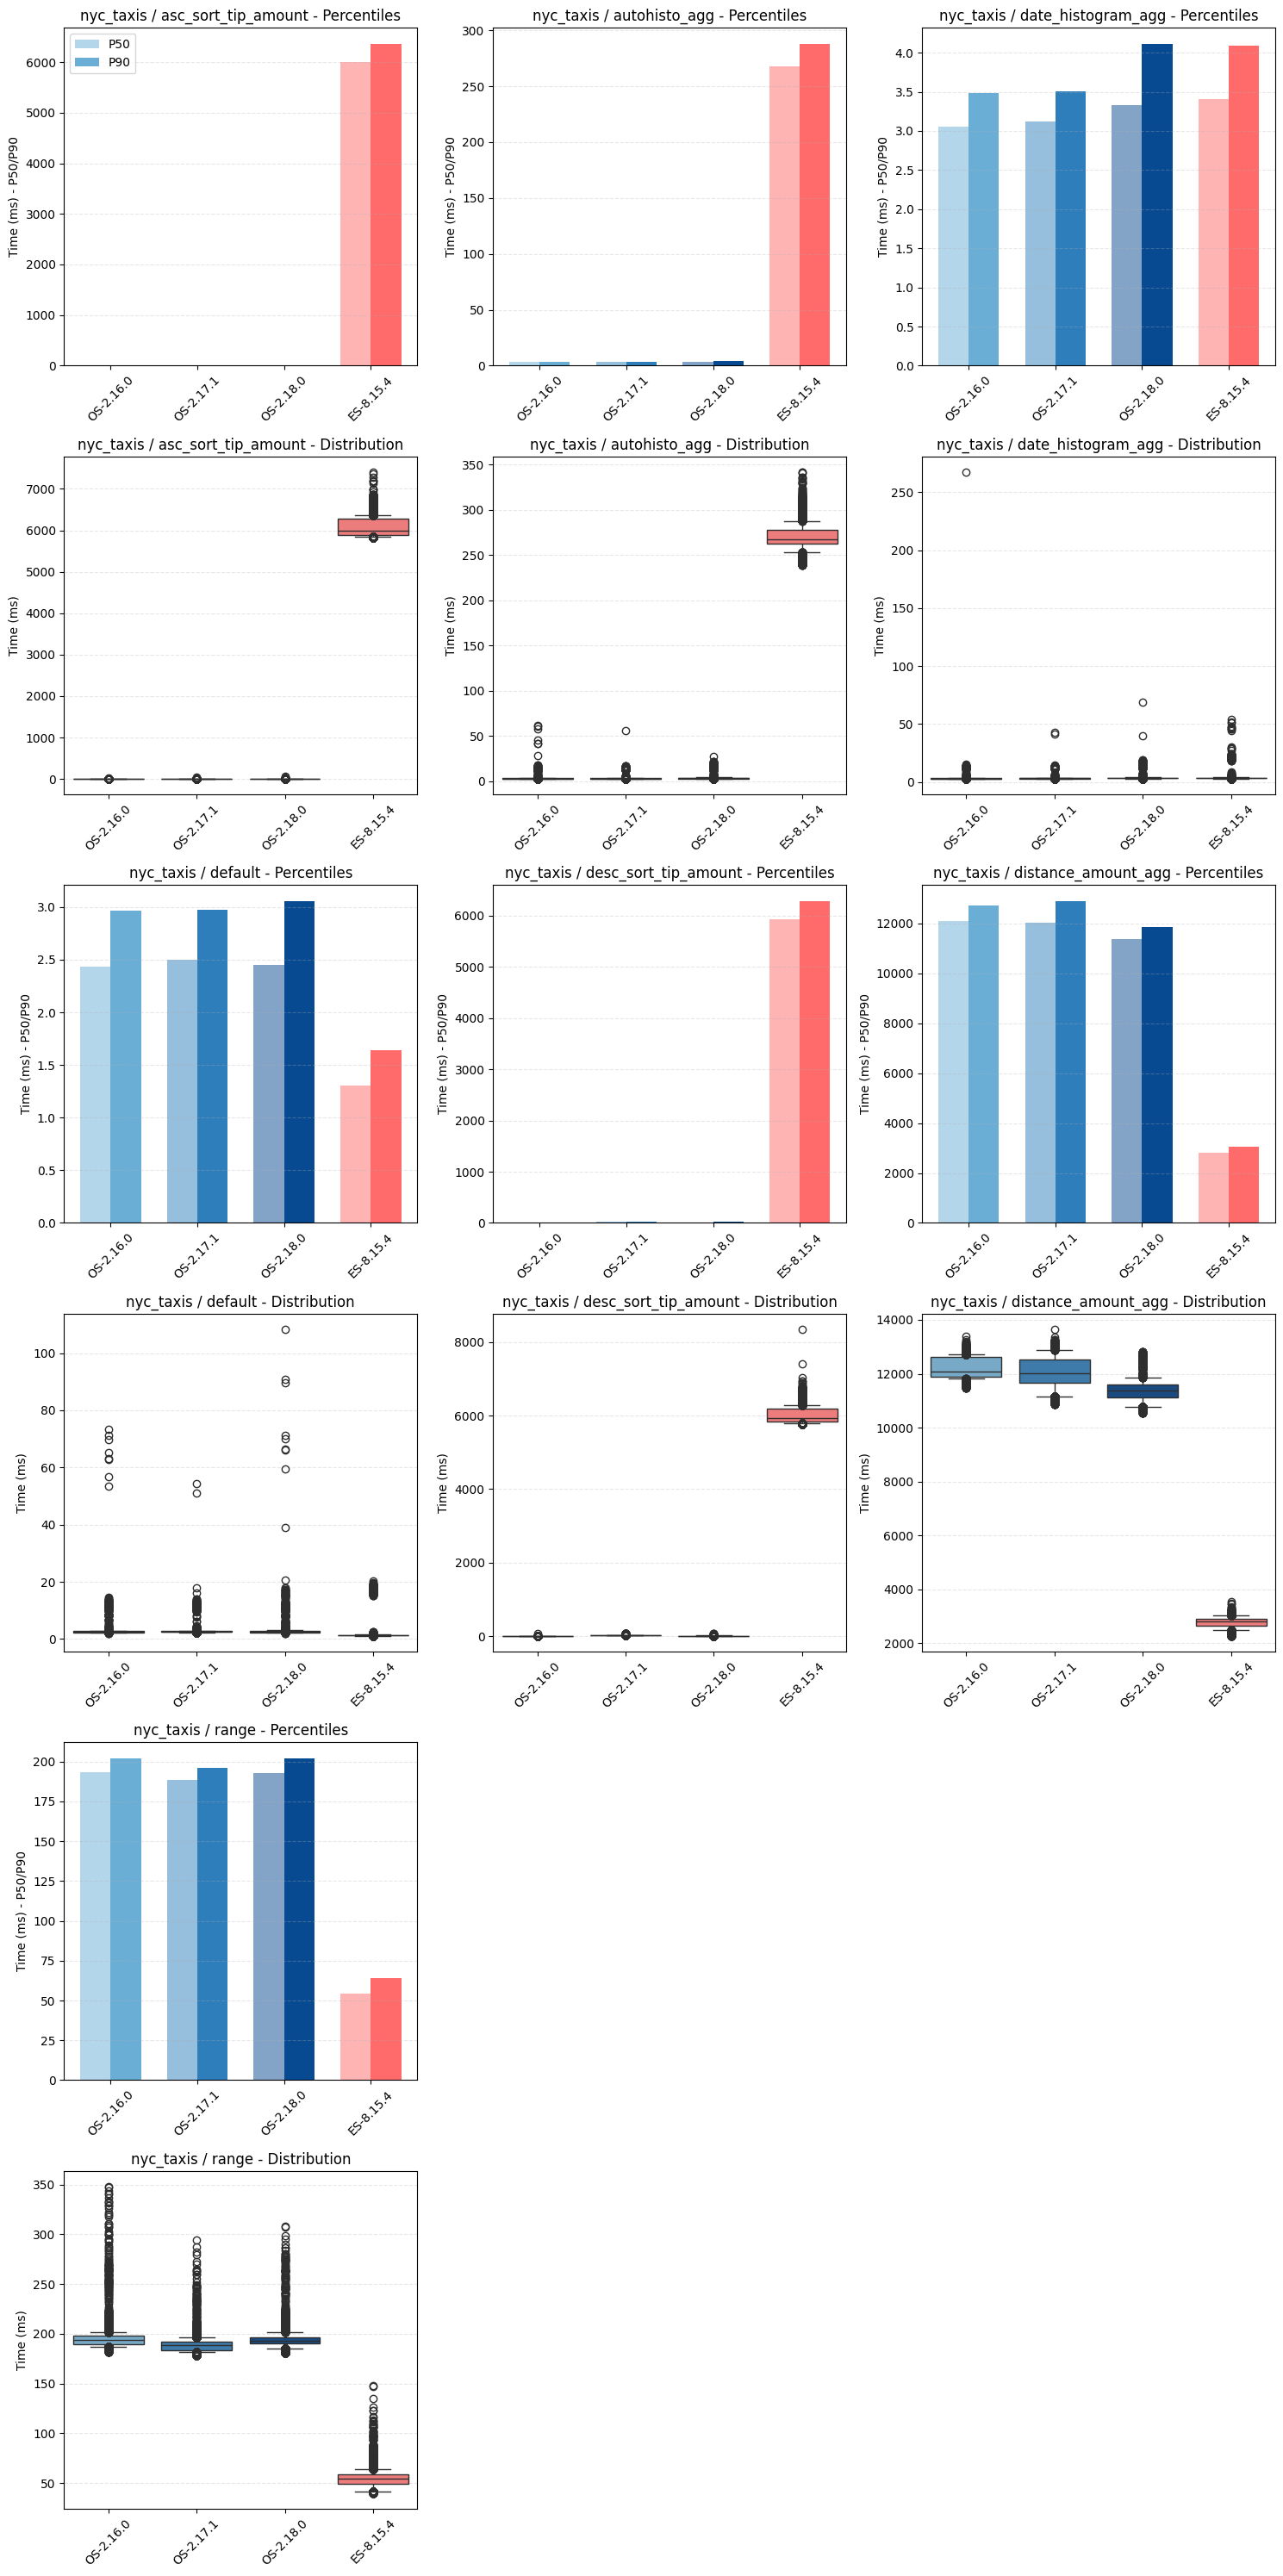



# pmc
Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
pmc / articles_monthly_agg_cached                                1.334ms (22.8%, p=0.00)         1.429ms (31.6%, p=0.00)         1.464ms (34.8%, p=0.00)         1.086ms (baseline)              
pmc / articles_monthly_agg_uncached                              5.515ms (-10.4%, p=0.00)        5.494ms (-10.8%, p=0.00)        5.837ms (-5.2%, p=0.00)         6.157ms (baseline)              
pmc / default                                                    2.638ms (3.7%, p=0.00)          2.687ms (5.7%, p=0.00)          3.136ms (23.3%, p=0.00)         2.543ms (baseline)    

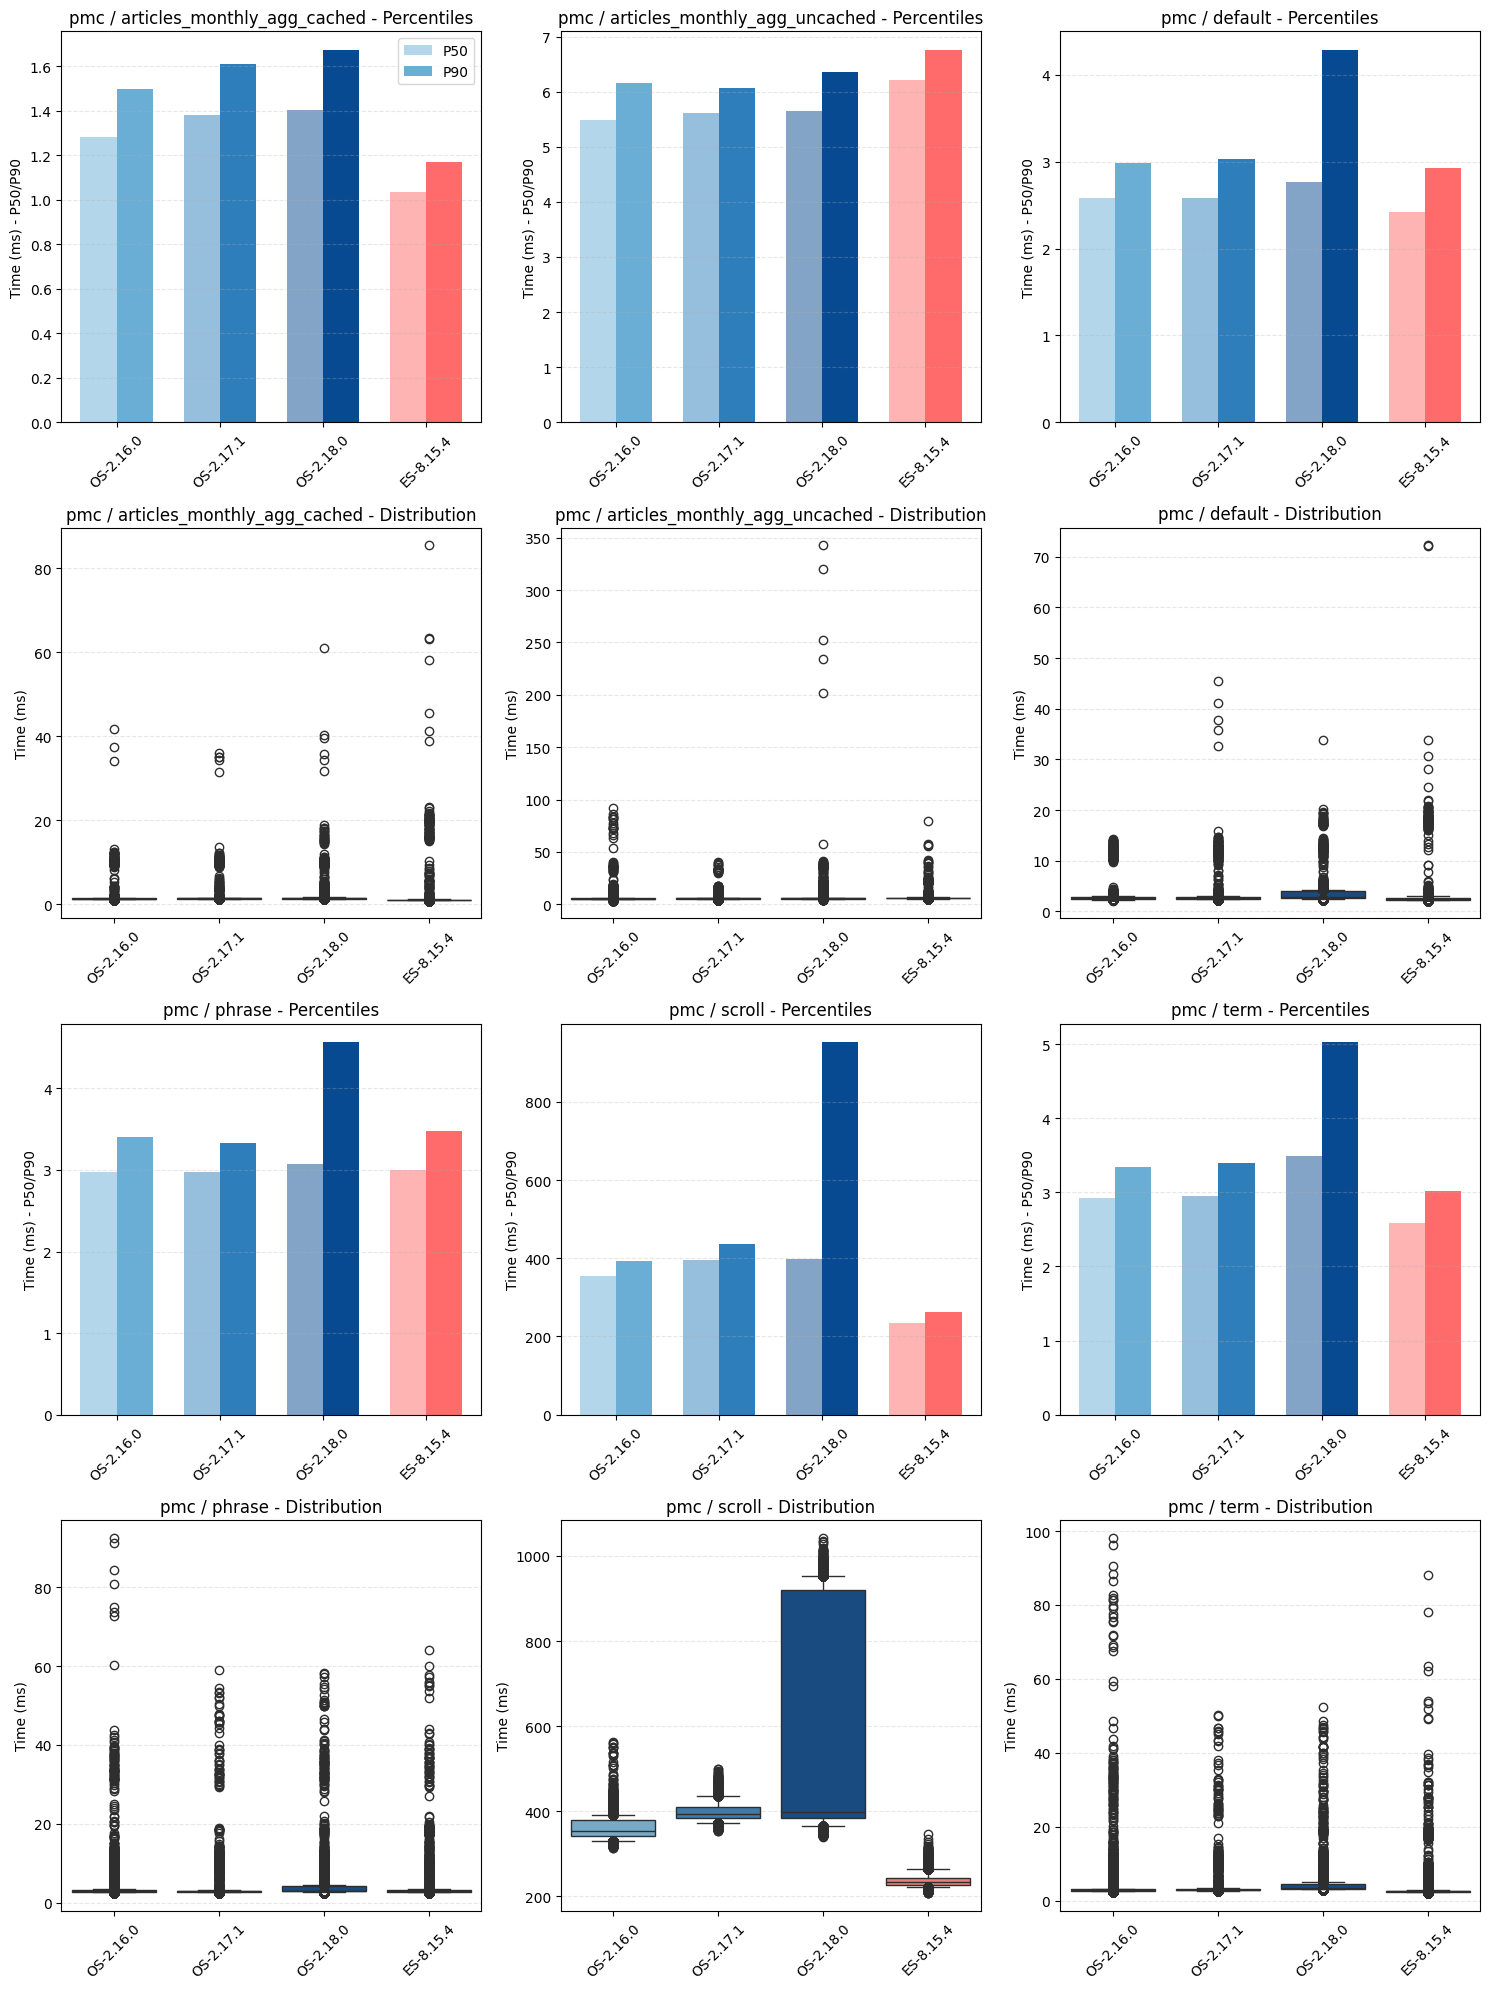



# noaa
Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
noaa / date-histo-entire-range                                   1.723ms (-8.3%, p=0.00)         1.720ms (-8.4%, p=0.00)         1.739ms (-7.4%, p=0.00)         1.879ms (baseline)              
noaa / date-histo-geohash-grid                                   1417.648ms (340.3%, p=0.00)     1380.504ms (328.8%, p=0.00)     1377.409ms (327.8%, p=0.00)     321.947ms (baseline)            
noaa / date-histo-geotile-grid                                   1868.085ms (427.4%, p=0.00)     1821.525ms (414.2%, p=0.00)     1824.533ms (415.1%, p=0.00)     354.235ms (baseline) 

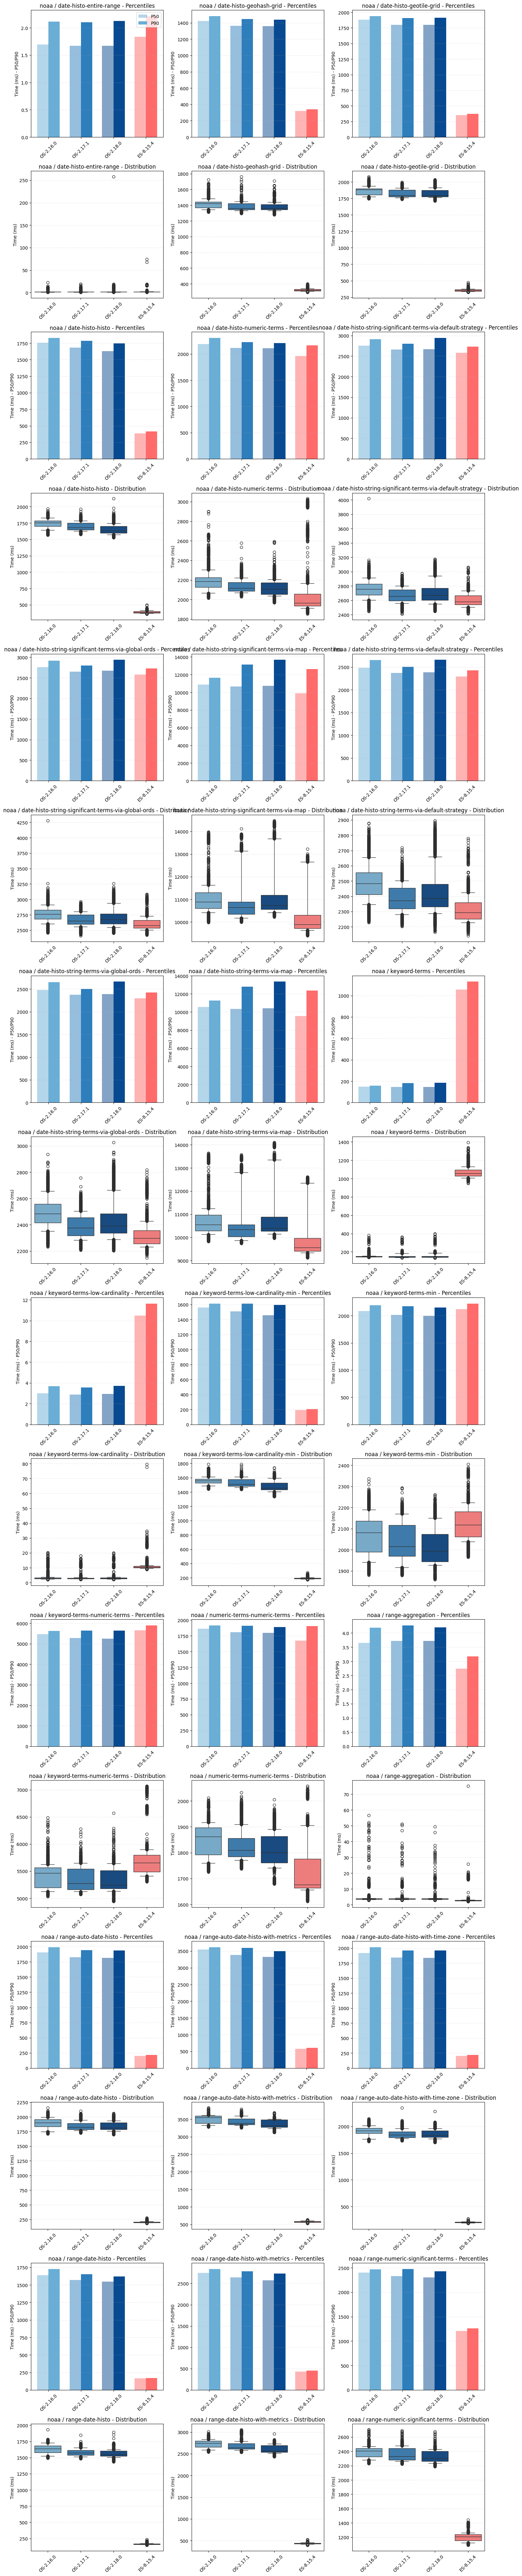

In [169]:
for workload in ["big5", "nyc_taxis", "pmc", "noaa"]:
    print(f"# {workload}")
    workload_df = filter_by_workload(df, workload)
    analyze_performance(workload_df, 'value')
    print()
    print()

# Check inconsistent tasks
These tasks in big5:
- composite-date_histogram-daily
- date_histogram_hourly_agg
- date_histogram_minute_agg
- keyword-terms
- keyword-terms-low-cardinality

have had quite a few outliers during our experiments. When one of these tasks is slower, also the others (in this list) are slower
- processor/cache/etc. are the same, so it’s not because of hardware, apparently
- inconsistencies happen on 2.16.0/2.17.1/2.18.0
- snapshots do not seem to be the problem, because same snapshots can have in one case the correct values and in others the much slower ones
- the only differences we have seen so far are:
    1. Total Young Gen GC time is >2.500s for the bad ones, it’s ~1.5s for the good ones
    2. Total Young Gen GC count is ~400s for the bad ones, ~150s for the good ones
    3. Store size is ~47gb for the bad ones, ~24 for the good ones


Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
big5 / composite-date_histogram-daily                            1.071ms (-99.9%, p=0.00)        1.155ms (-99.9%, p=0.00)        1.125ms (-99.9%, p=0.00)        1642.594ms (baseline)           
big5 / date_histogram_hourly_agg                                 4.755ms (-99.6%, p=0.00)        4.769ms (-99.6%, p=0.00)        4.772ms (-99.6%, p=0.00)        1344.924ms (baseline)           
big5 / date_histogram_minute_agg                                 33.090ms (-97.3%, p=0.00)       32.797ms (-97.3%, p=0.00)       32.822ms (-97.3%, p=0.00)       1231.564ms (baseline)         

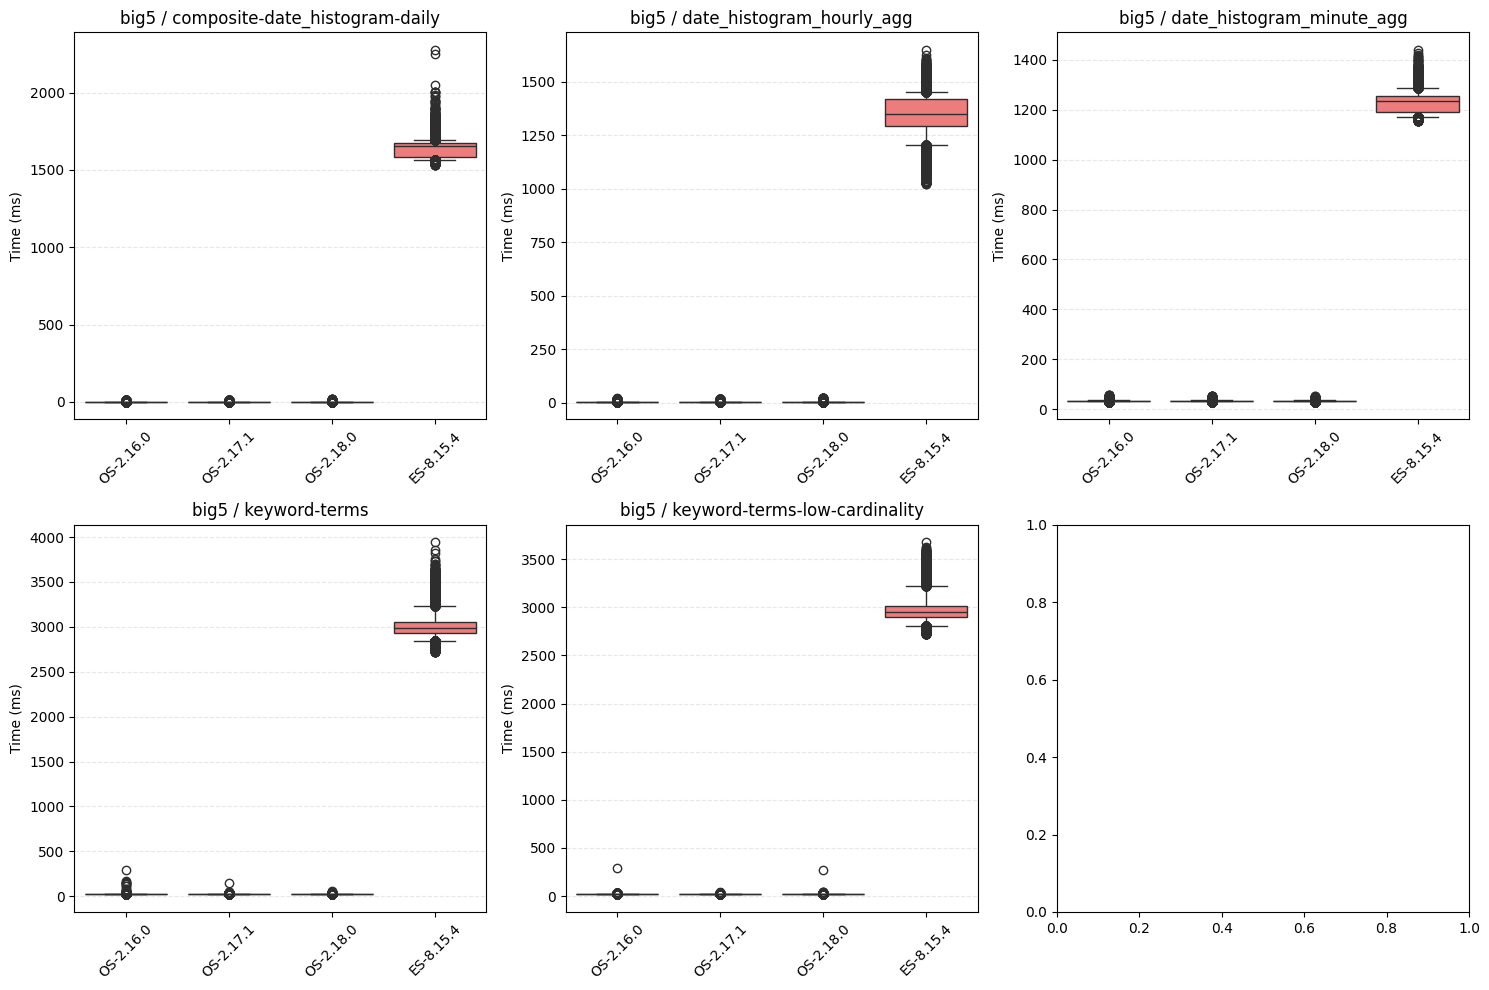

In [ ]:
big5_df = filter_by_workload(df, "big5")
inconsistent_tasks = ["composite-date_histogram-daily", "date_histogram_hourly_agg", "date_histogram_minute_agg", "keyword-terms", "keyword-terms-low-cardinality"]
inconsistent_tasks = ["big5 / " + s for s in inconsistent_tasks]
# Get only the inconsistent tasks
big5_df = big5_df[big5_df['task'].isin(inconsistent_tasks)]

analyze_performance(big5_df, 'value', use_percentile=False)

# Tasks where OS is much faster than ES

In [171]:
def filter_tasks_by_performance(df, value_field='value', os_faster=True, threshold_percent=20, p_value_threshold=0.05):
    """
    Filter tasks based on performance difference between OS and ES.
    
    Args:
        df: DataFrame with performance data
        value_field: Column name containing the values to analyze
        os_faster: If True, find tasks where OS is faster. If False, find where ES is faster
        threshold_percent: Minimum percentage difference to consider (default 20%)
        p_value_threshold: Statistical significance threshold (default 0.05)
    
    Returns:
        DataFrame containing only the tasks meeting the criteria
    """
    ddf = df.copy()
    ddf["task"] = ddf["workload"] + " / " + ddf["operation"]
    results, os_statistics, all_versions = get_performance_summary(ddf, value_field)
    if not results:
        return None
    
    # Get ES baseline version
    es_versions = [v for v in all_versions if v.startswith('ES')]
    baseline_version = es_versions[0]
    
    # Filter tasks based on criteria
    filtered_tasks = []
    for r in results:
        task = r['task']
        stats = r['stats']
        
        # Check if this task shows consistent behavior across OS versions
        os_versions_faster = 0
        os_versions_slower = 0
        total_os_versions = sum(1 for v in stats if v.startswith('OS'))
        
        for version, stat in stats.items():
            if version.startswith('OS'):
                if not stat['is_baseline']:
                    # Check if difference is statistically significant
                    if stat['p_value'] < p_value_threshold:
                        if os_faster:
                            # OS should be faster (negative percent diff)
                            if stat['percent_diff'] < -threshold_percent:
                                os_versions_faster += 1
                        else:
                            # ES should be faster (positive percent diff)
                            if stat['percent_diff'] > threshold_percent:
                                os_versions_slower += 1
        
        # Add task if majority of OS versions show the desired behavior
        threshold_versions = total_os_versions / 2
        if os_faster and os_versions_faster > threshold_versions:
            filtered_tasks.append(task)
        elif not os_faster and os_versions_slower > threshold_versions:
            filtered_tasks.append(task)
    
    # Filter the original dataframe to include only the identified tasks
    if filtered_tasks:
        filtered_df = ddf[ddf['task'].isin(filtered_tasks)].copy()
        return filtered_df
    else:
        print("No tasks found meeting the criteria!")
        return None

def analyze_performance_difference(df, value_field='value', threshold_percent=20):
    """
    Analyze and visualize tasks where there's a significant performance difference
    between OS and ES versions.
    
    Args:
        df: DataFrame with performance data
        value_field: Column name containing the values to analyze
        threshold_percent: Minimum percentage difference to consider
    """
    print(f"\nAnalyzing tasks where OS is significantly faster (>{threshold_percent}%):")
    print("=" * 80)
    os_faster_df = filter_tasks_by_performance(df, value_field, os_faster=True, 
                                             threshold_percent=threshold_percent)
    if os_faster_df is not None:
        analyze_performance(os_faster_df, value_field)
    
    print(f"\nAnalyzing tasks where ES is significantly faster (>{threshold_percent}%):")
    print("=" * 80)
    es_faster_df = filter_tasks_by_performance(df, value_field, os_faster=False, 
                                             threshold_percent=threshold_percent)
    if es_faster_df is not None:
        analyze_performance(es_faster_df, value_field)


Analyzing tasks where OS is significantly faster (>20%):
Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
big5 / asc_sort_timestamp                                        4.890ms (-78.6%, p=0.00)        4.997ms (-78.1%, p=0.00)        5.038ms (-78.0%, p=0.00)        22.854ms (baseline)             
big5 / asc_sort_timestamp_can_match_shortcut                     4.938ms (-73.8%, p=0.00)        5.062ms (-73.1%, p=0.00)        5.253ms (-72.1%, p=0.00)        18.839ms (baseline)             
big5 / asc_sort_timestamp_no_can_match_shortcut                  4.946ms (-73.8%, p=0.00)        5.085ms (-73.0%, p=0.00)        5.25

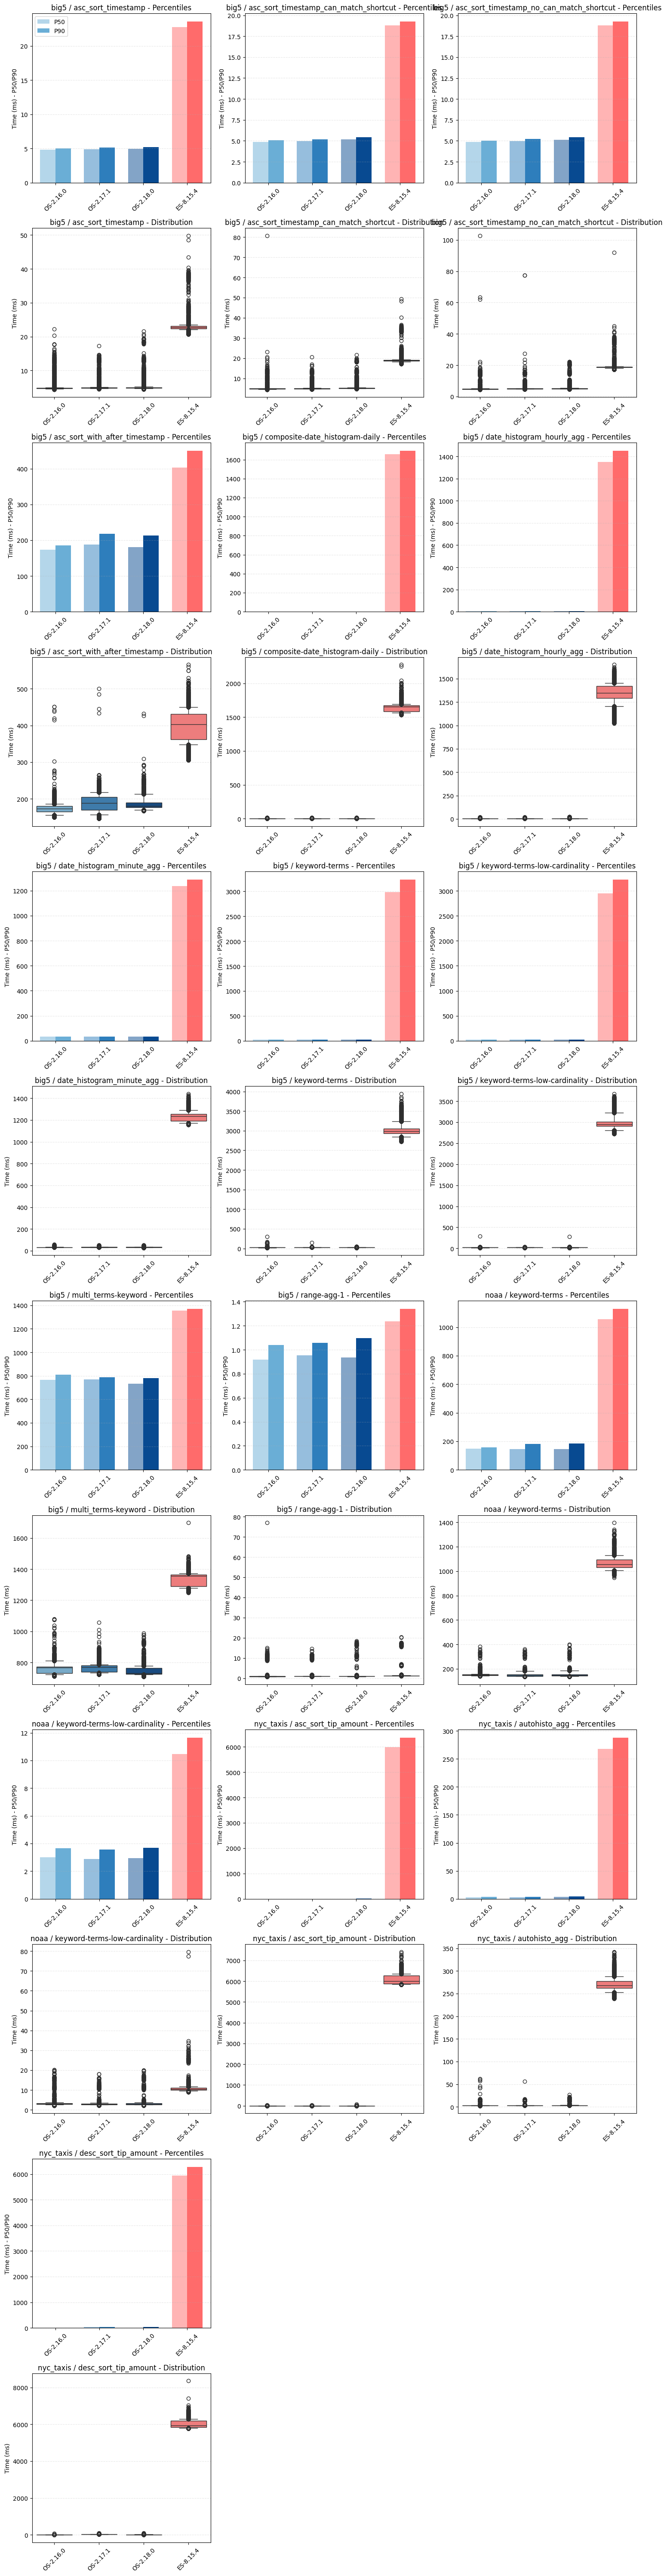


Analyzing tasks where ES is significantly faster (>20%):
Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
big5 / cardinality-agg-high                                      2397.419ms (237.3%, p=0.00)     2390.819ms (236.4%, p=0.00)     2312.275ms (225.3%, p=0.00)     710.796ms (baseline)            
big5 / cardinality-agg-low                                       1.783ms (74.9%, p=0.00)         1.821ms (78.5%, p=0.00)         1.804ms (76.9%, p=0.00)         1.020ms (baseline)              
big5 / default                                                   2.280ms (74.3%, p=0.00)         2.301ms (75.9%, p=0.00)         2.28

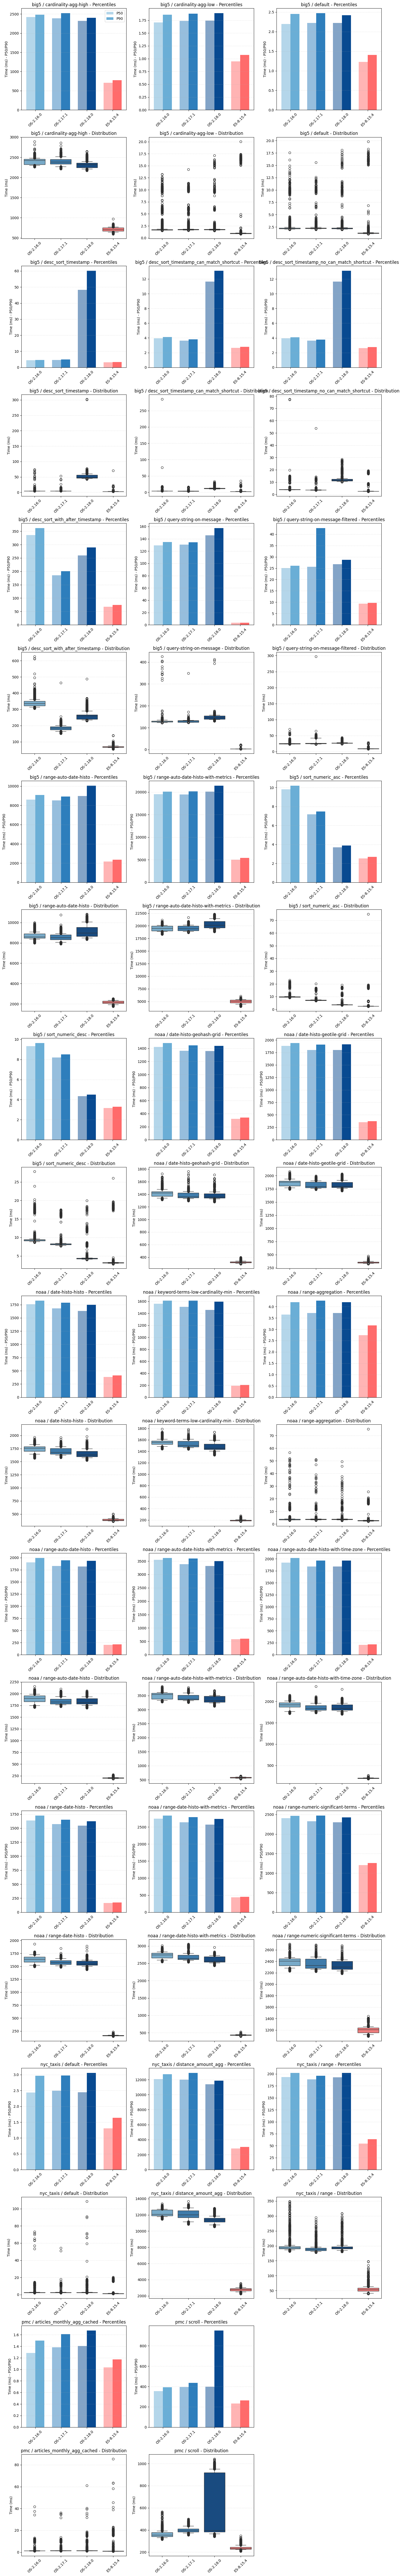

In [172]:
analyze_performance_difference(df, 'value (milliseconds)')

# OS performance regressions

In [173]:
def analyze_os_regressions(df, value_field='value', threshold_percent=20, p_value_threshold=0.05):
    """
    Analyze performance regressions across OS versions.
    Identifies tasks where newer OS versions perform worse than older ones.
    
    Args:
        df: DataFrame with performance data
        value_field: Column name containing the values to analyze
        threshold_percent: Minimum percentage difference to consider regression
        p_value_threshold: Statistical significance threshold
    
    Returns:
        DataFrame containing only the tasks with regressions
    """
    ddf = df.copy()
    ddf["task"] = ddf["workload"] + " / " + ddf["operation"]
    results, os_statistics, all_versions = get_performance_summary(ddf, value_field)
    if not results:
        return None
    
    # Get OS versions in chronological order
    os_versions = [v for v in all_versions if v.startswith('OS')]
    os_versions.sort(key=lambda v: v.split('-')[1])  # Sort by version number
    
    # Store tasks with regressions
    regression_tasks = []
    regression_details = []
    
    for r in results:
        task = r['task']
        st = r['stats']
        
        has_regression = False
        
        # Compare each version with its predecessor
        for i in range(1, len(os_versions)):
            newer_version = os_versions[i]
            older_version = os_versions[i-1]
            
            # Check if we have data for both versions
            if newer_version in st and older_version in st:
                newer_stats = st[newer_version]
                older_stats = st[older_version]
                
                if not newer_stats['is_baseline'] and not older_stats['is_baseline']:
                    # Calculate performance difference
                    perf_diff = ((newer_stats['mean'] - older_stats['mean']) / older_stats['mean']) * 100
                    
                    # Check if difference is statistically significant
                    task_data = ddf[ddf['task'] == task]
                    newer_data = task_data[task_data['engine_version'] == newer_version][value_field]
                    older_data = task_data[task_data['engine_version'] == older_version][value_field]
                    
                    if len(newer_data) > 0 and len(older_data) > 0:
                        _, p_value = stats.mannwhitneyu(newer_data, older_data, alternative='two-sided')
                        
                        # If newer version is significantly slower
                        if p_value < p_value_threshold and perf_diff > threshold_percent:
                            has_regression = True
                            regression_details.append({
                                'task': task,
                                'older_version': older_version,
                                'newer_version': newer_version,
                                'regression_percent': perf_diff,
                                'p_value': p_value,
                                'older_mean': older_stats['mean'],
                                'newer_mean': newer_stats['mean']
                            })
        
        if has_regression:
            regression_tasks.append(task)
    
    # Print regression details
    if regression_details:
        print("\nDetected Performance Regressions:")
        print("=" * 100)
        for detail in sorted(regression_details, key=lambda x: x['regression_percent'], reverse=True):
            print(f"\nTask: {detail['task']}")
            print(f"Regression: {detail['older_version']} → {detail['newer_version']}")
            print(f"Performance impact: {detail['regression_percent']:.1f}% slower")
            print(f"Mean time: {detail['older_mean']:.2f}ms → {detail['newer_mean']:.2f}ms")
            print(f"Statistical significance: p={detail['p_value']:.4f}")
        
        # Filter the original dataframe to include only the regression tasks
        filtered_df = ddf[ddf['task'].isin(regression_tasks)].copy()
        return filtered_df
    else:
        print("No significant regressions found!")
        return None

def analyze_os_performance_trends(df, value_field='value', threshold_percent=20):
    """
    Analyze and visualize OS version regressions.
    
    Args:
        df: DataFrame with performance data
        value_field: Column name containing the values to analyze
        threshold_percent: Minimum percentage difference to consider regression
    """
    print(f"\nAnalyzing OS version regressions (threshold: {threshold_percent}%):")
    regression_df = analyze_os_regressions(df, value_field, threshold_percent=threshold_percent)
    
    if regression_df is not None:
        print("\nVisualizing tasks with regressions:")
        analyze_performance(regression_df, value_field)


Analyzing OS version regressions (threshold: 20%):

Detected Performance Regressions:

Task: big5 / desc_sort_timestamp
Regression: OS-2.17.1 → OS-2.18.0
Performance impact: 978.7% slower
Mean time: 4.72ms → 50.89ms
Statistical significance: p=0.0000

Task: nyc_taxis / desc_sort_tip_amount
Regression: OS-2.16.0 → OS-2.17.1
Performance impact: 704.4% slower
Mean time: 3.63ms → 29.19ms
Statistical significance: p=0.0000

Task: big5 / keyword-in-range
Regression: OS-2.17.1 → OS-2.18.0
Performance impact: 418.4% slower
Mean time: 12.02ms → 62.33ms
Statistical significance: p=0.0000

Task: big5 / desc_sort_timestamp_no_can_match_shortcut
Regression: OS-2.17.1 → OS-2.18.0
Performance impact: 219.6% slower
Mean time: 3.68ms → 11.78ms
Statistical significance: p=0.0000

Task: big5 / desc_sort_timestamp_can_match_shortcut
Regression: OS-2.17.1 → OS-2.18.0
Performance impact: 217.9% slower
Mean time: 3.70ms → 11.77ms
Statistical significance: p=0.0000

Task: big5 / desc_sort_with_after_timestam

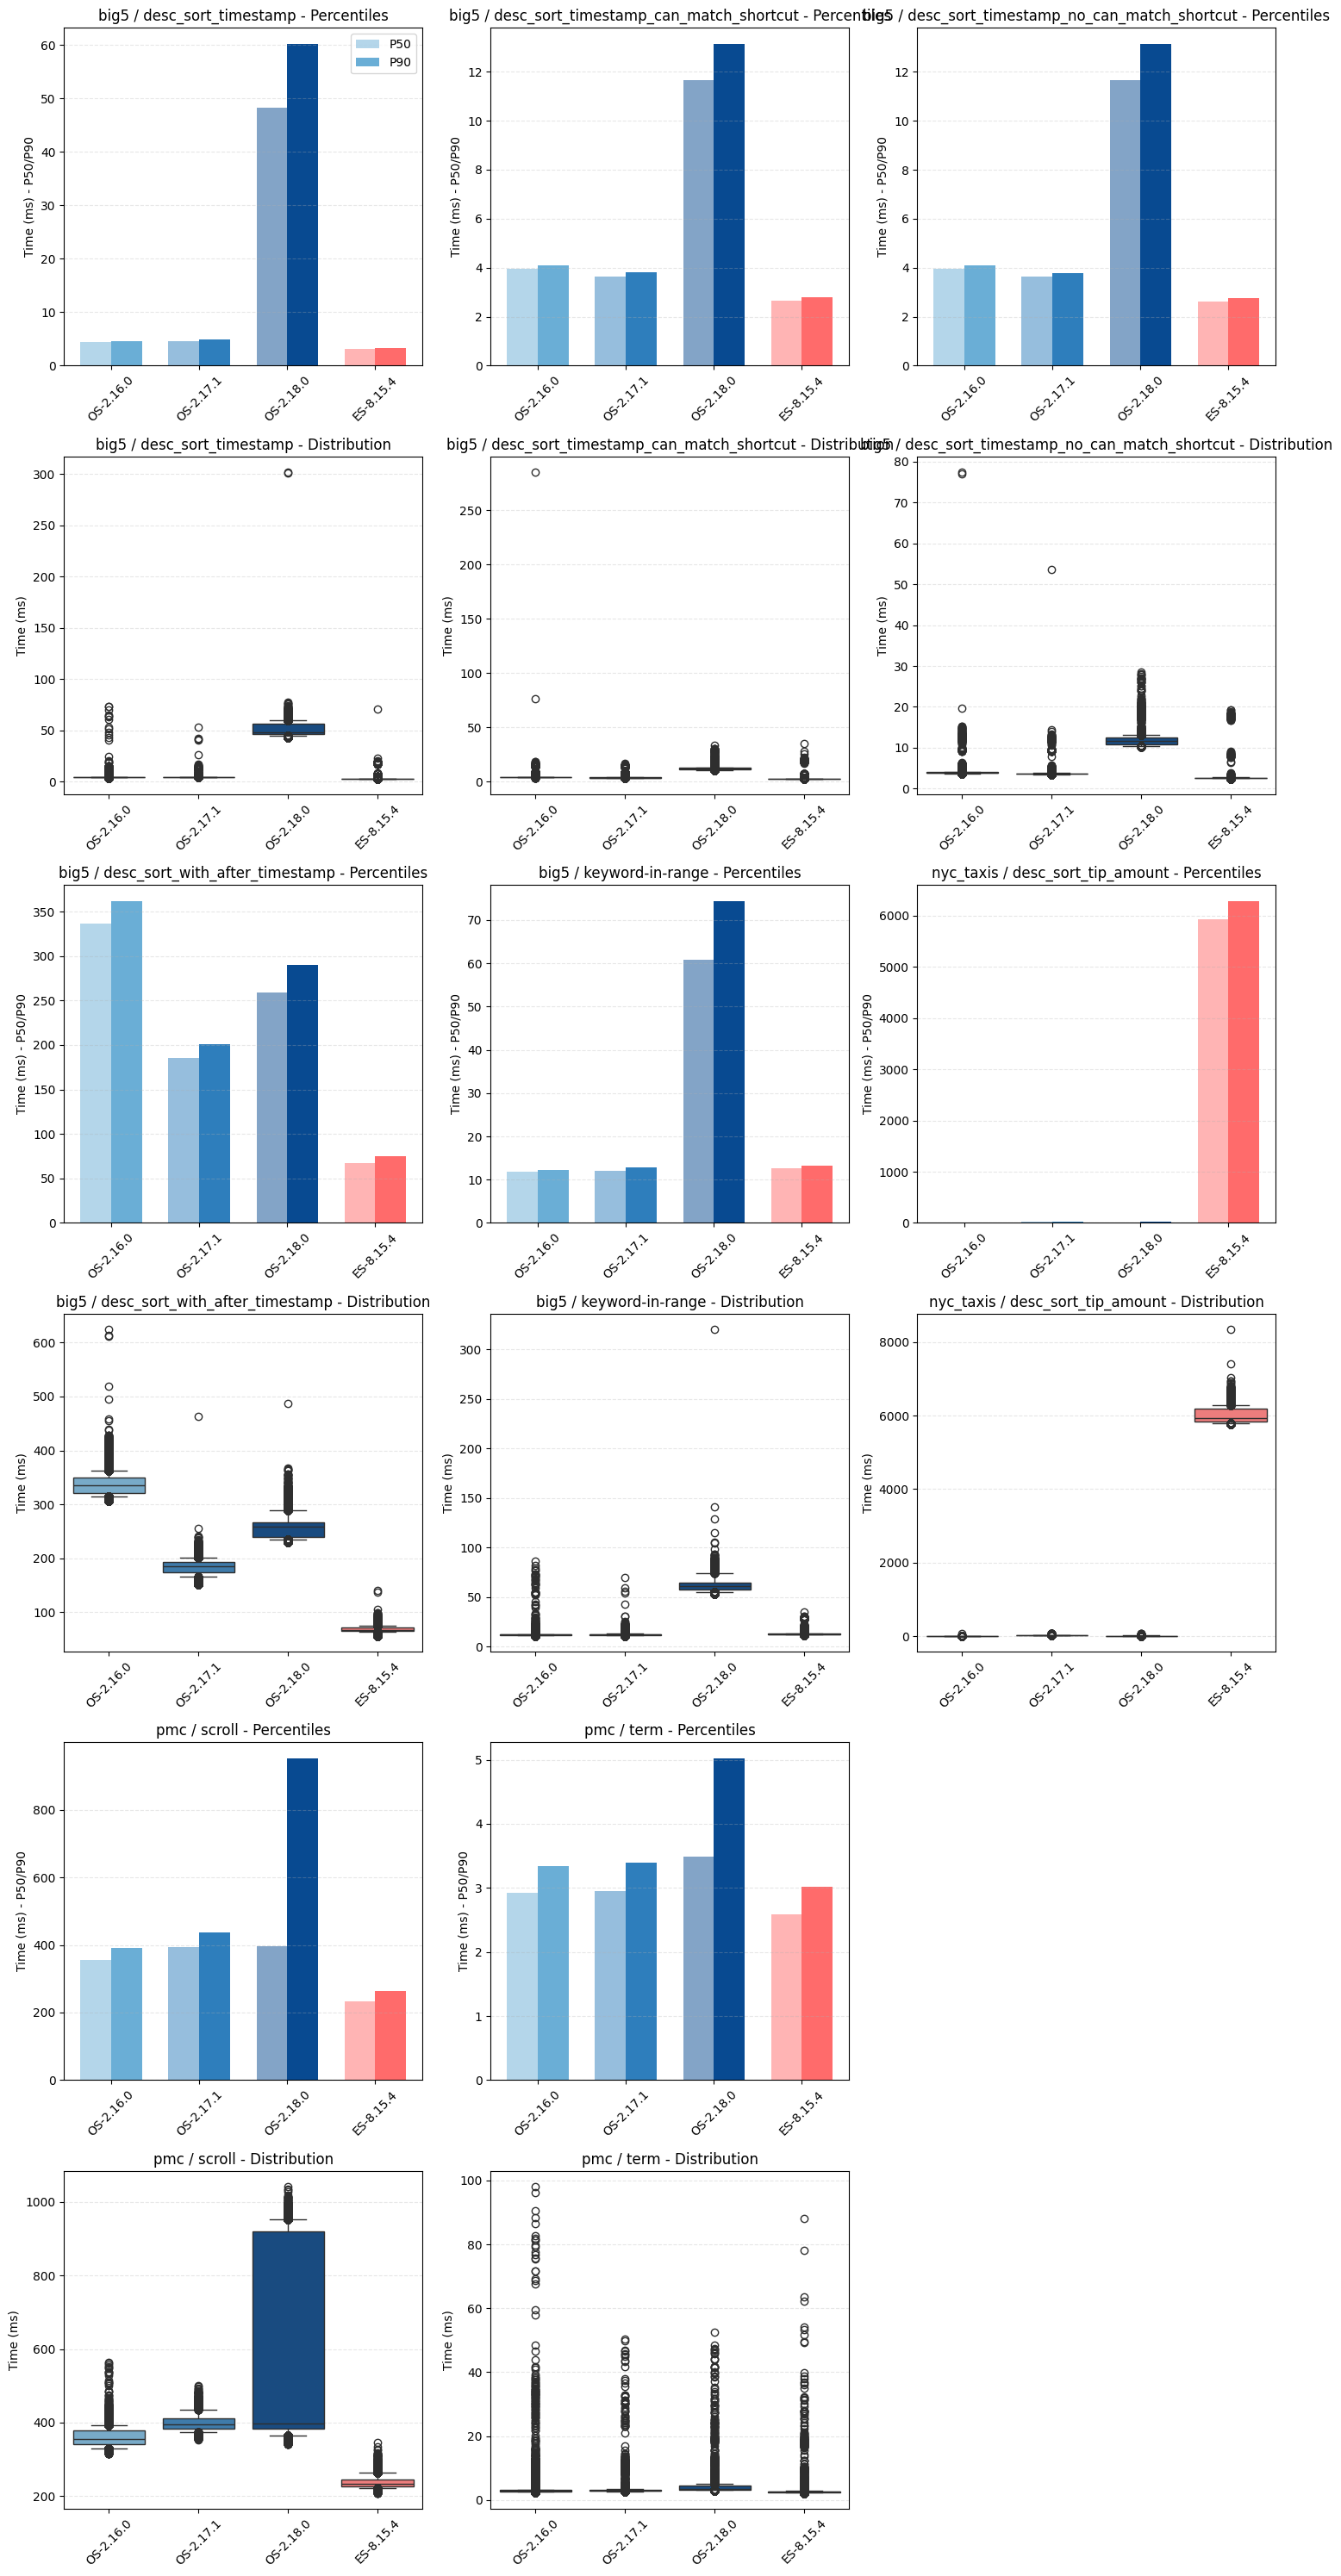

In [174]:
analyze_os_performance_trends(df, 'value')

# OS improvements

In [175]:
def analyze_os_improvements(df, value_field='value', threshold_percent=20, p_value_threshold=0.05):
    """
    Analyze performance improvements across OS versions.
    Identifies tasks where newer OS versions perform better than older ones.
    
    Args:
        df: DataFrame with performance data
        value_field: Column name containing the values to analyze
        threshold_percent: Minimum percentage improvement to consider
        p_value_threshold: Statistical significance threshold
    
    Returns:
        DataFrame containing only the tasks with improvements
    """
    ddf = df.copy()
    ddf["task"] = ddf["workload"] + " / " + ddf["operation"]
    results, os_statistics, all_versions = get_performance_summary(ddf, value_field)
    if not results:
        return None
    
    # Get OS versions in chronological order
    os_versions = [v for v in all_versions if v.startswith('OS')]
    os_versions.sort(key=lambda v: v.split('-')[1])  # Sort by version number
    
    # Store tasks with improvements
    improved_tasks = []
    improvement_details = []
    
    for r in results:
        task = r['task']
        st = r['stats']
        
        has_improvement = False
        
        # Compare each version with its predecessor
        for i in range(1, len(os_versions)):
            newer_version = os_versions[i]
            older_version = os_versions[i-1]
            
            # Check if we have data for both versions
            if newer_version in st and older_version in st:
                newer_stats = st[newer_version]
                older_stats = st[older_version]
                
                if not newer_stats['is_baseline'] and not older_stats['is_baseline']:
                    # Calculate performance difference (negative means improvement)
                    perf_diff = ((newer_stats['mean'] - older_stats['mean']) / older_stats['mean']) * 100
                    
                    # Check if difference is statistically significant
                    task_data = ddf[ddf['task'] == task]
                    newer_data = task_data[task_data['engine_version'] == newer_version][value_field]
                    older_data = task_data[task_data['engine_version'] == older_version][value_field]
                    
                    if len(newer_data) > 0 and len(older_data) > 0:
                        _, p_value = stats.mannwhitneyu(newer_data, older_data, alternative='two-sided')
                        
                        # If newer version is significantly faster
                        if p_value < p_value_threshold and perf_diff < -threshold_percent:
                            has_improvement = True
                            improvement_details.append({
                                'task': task,
                                'older_version': older_version,
                                'newer_version': newer_version,
                                'improvement_percent': -perf_diff,  # Make positive for readability
                                'p_value': p_value,
                                'older_mean': older_stats['mean'],
                                'newer_mean': newer_stats['mean']
                            })
        
        if has_improvement:
            improved_tasks.append(task)
    
    # Print improvement details
    if improvement_details:
        print("\nDetected Performance Improvements:")
        print("=" * 100)
        for detail in sorted(improvement_details, key=lambda x: x['improvement_percent'], reverse=True):
            print(f"\nTask: {detail['task']}")
            print(f"Improvement: {detail['older_version']} → {detail['newer_version']}")
            print(f"Performance impact: {detail['improvement_percent']:.1f}% faster")
            print(f"Mean time: {detail['older_mean']:.2f}ms → {detail['newer_mean']:.2f}ms")
            print(f"Statistical significance: p={detail['p_value']:.4f}")
        
        # Filter the original dataframe to include only the improved tasks
        filtered_df = ddf[ddf['task'].isin(improved_tasks)].copy()
        return filtered_df
    else:
        print("No significant improvements found!")
        return None

def analyze_os_performance_improvements(df, value_field='value', threshold_percent=20):
    """
    Analyze and visualize OS version improvements.
    
    Args:
        df: DataFrame with performance data
        value_field: Column name containing the values to analyze
        threshold_percent: Minimum percentage improvement to consider
    """
    print(f"\nAnalyzing OS version improvements (threshold: {threshold_percent}%):")
    improved_df = analyze_os_improvements(df, value_field, threshold_percent=threshold_percent)
    
    if improved_df is not None:
        print("\nVisualizing tasks with improvements:")
        analyze_performance(improved_df, value_field)


Analyzing OS version improvements (threshold: 20%):

Detected Performance Improvements:

Task: nyc_taxis / desc_sort_tip_amount
Improvement: OS-2.17.1 → OS-2.18.0
Performance impact: 74.9% faster
Mean time: 29.19ms → 7.33ms
Statistical significance: p=0.0000

Task: big5 / sort_numeric_asc
Improvement: OS-2.17.1 → OS-2.18.0
Performance impact: 48.4% faster
Mean time: 7.22ms → 3.72ms
Statistical significance: p=0.0000

Task: big5 / sort_numeric_desc
Improvement: OS-2.17.1 → OS-2.18.0
Performance impact: 46.8% faster
Mean time: 8.22ms → 4.37ms
Statistical significance: p=0.0000

Task: big5 / desc_sort_with_after_timestamp
Improvement: OS-2.16.0 → OS-2.17.1
Performance impact: 45.3% faster
Mean time: 336.79ms → 184.32ms
Statistical significance: p=0.0000

Task: big5 / sort_numeric_asc
Improvement: OS-2.16.0 → OS-2.17.1
Performance impact: 27.0% faster
Mean time: 9.88ms → 7.22ms
Statistical significance: p=0.0000

Visualizing tasks with improvements:
Performance Summary Across Tasks
Task  

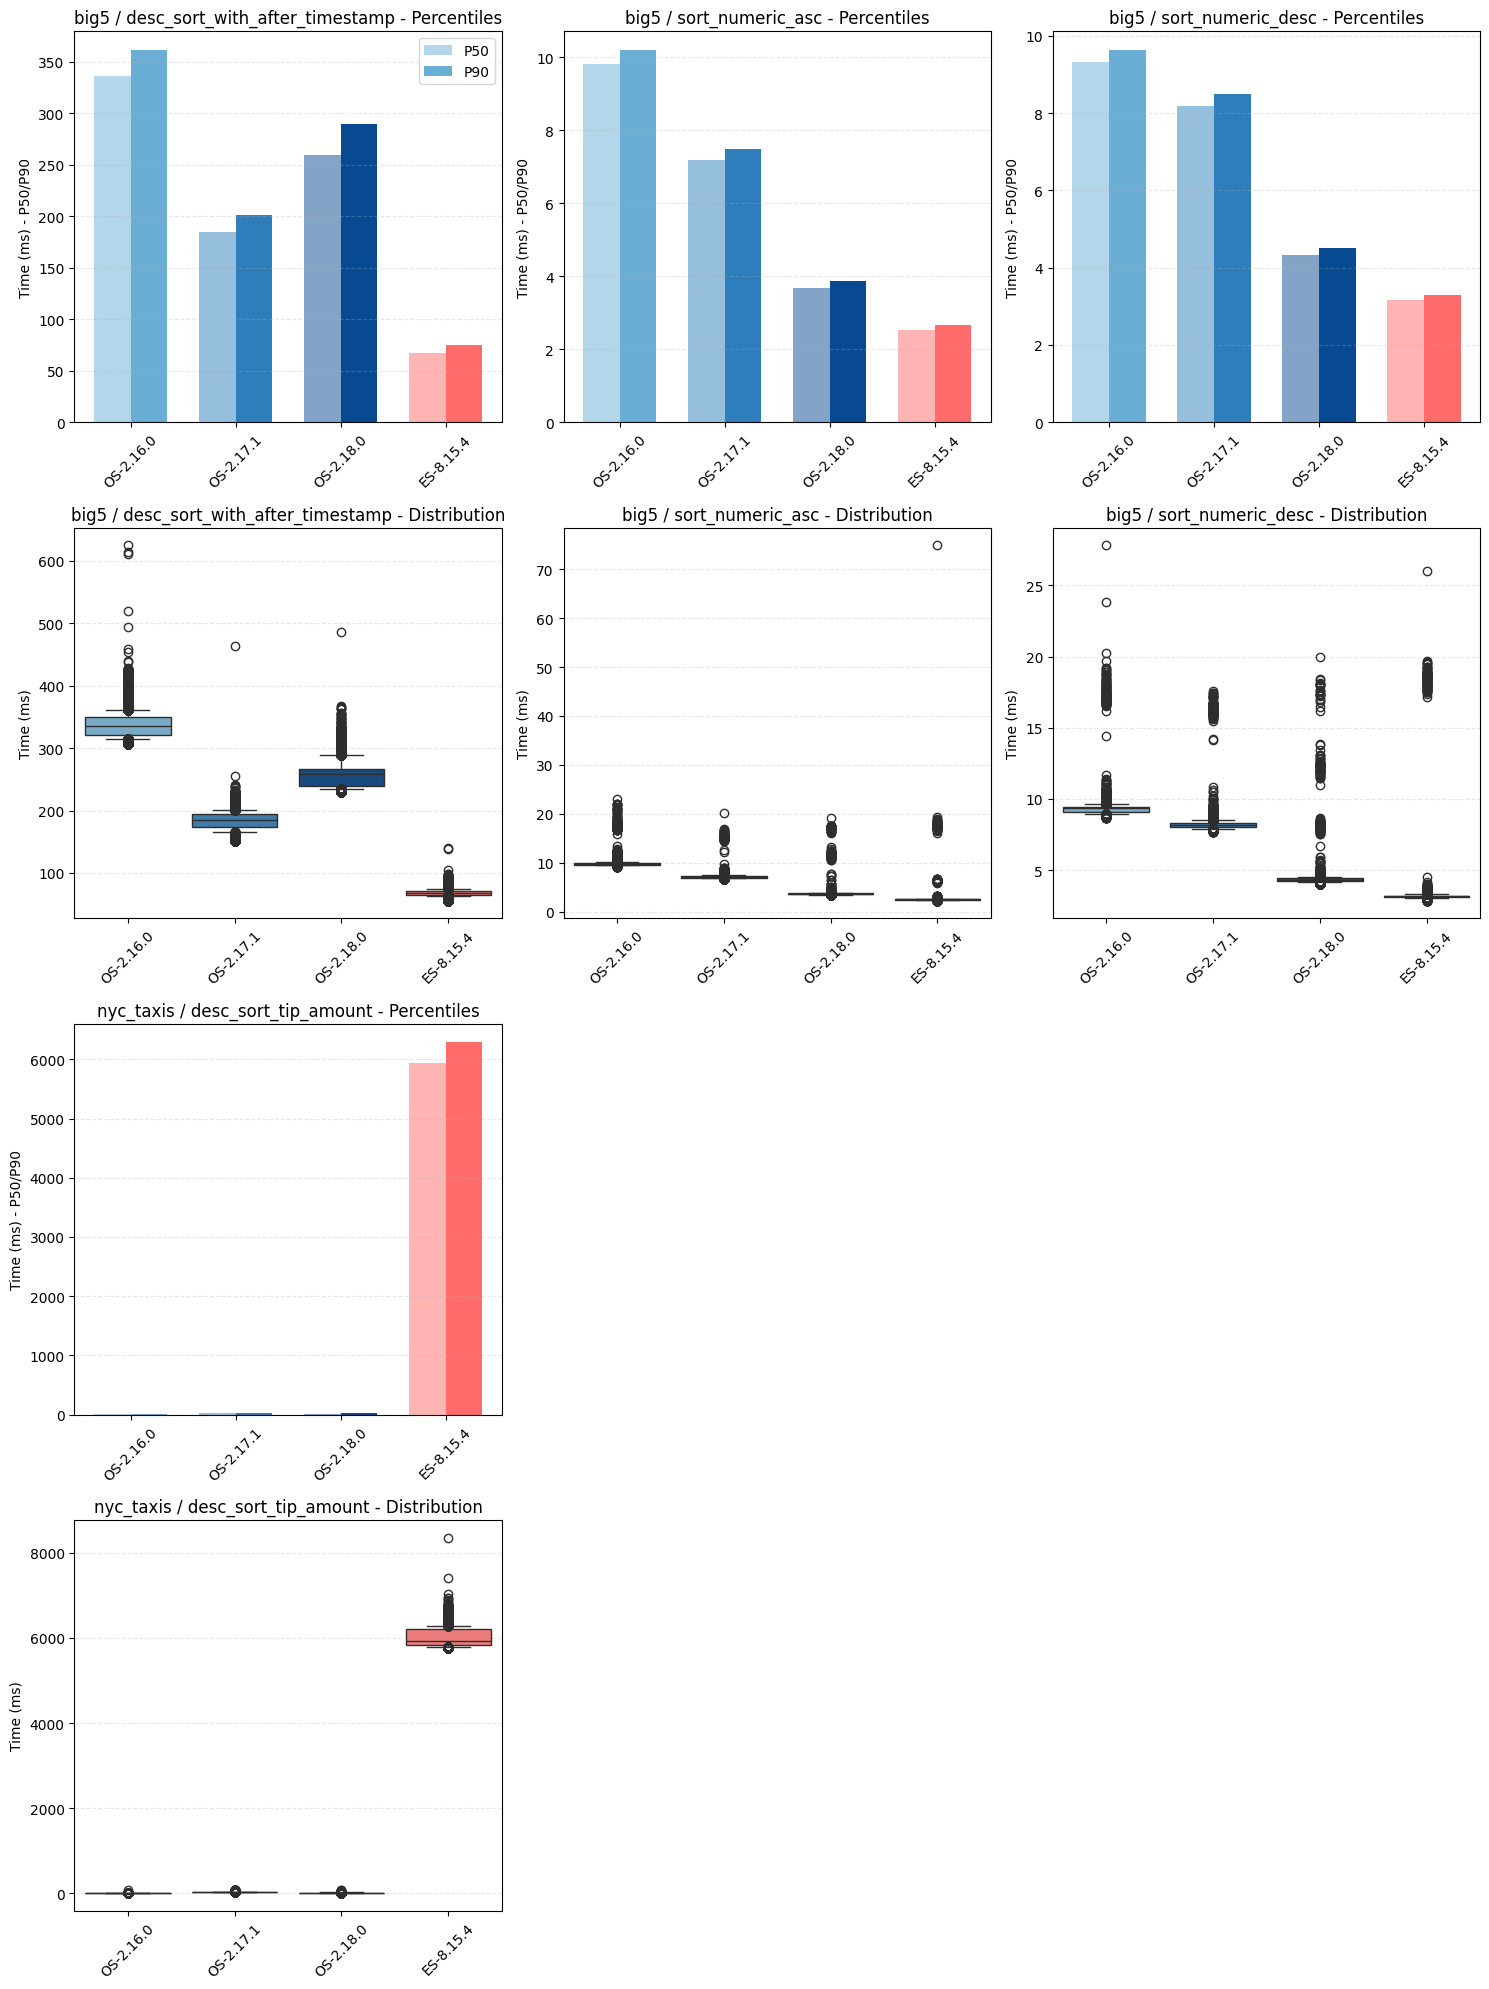

In [176]:
analyze_os_performance_improvements(df, 'value')

# Differences across OS versions

In [177]:
def compare_os_versions(df, value_field = 'value', version1='2.17.1', version2='2.18.0'):
    """
    Compare performance between two specific OS versions.
    Args:
        df: DataFrame with performance data
        version1: First OS version to compare (default: '2.17.1')
        version2: Second OS version to compare (default: '2.18.0')
    """
    version1_full = f'OS-{version1}'
    version2_full = f'OS-{version2}'
    
    # Filter for just the two versions we want to compare
    mask = df['engine_version'].isin([version1_full, version2_full])
    comparison_df = df[mask]
    
    if len(comparison_df) == 0:
        print(f"No data found for versions {version1_full} and {version2_full}")
        return
    
    results = {
        'improved': [],
        'degraded': [],
        'similar': []
    }
    
    print(f"\nComparing {version2_full} against {version1_full}")
    print("=" * 100)
    print(f"{'Task':<60} {'Change %':<10} {'p-value':<10} {'Verdict':<10}")
    print("-" * 100)
    
    for task in sorted(comparison_df['task'].unique()):
        task_data = comparison_df[comparison_df['task'] == task]
        
        v1_data = task_data[task_data['engine_version'] == version1_full][value_field]
        v2_data = task_data[task_data['engine_version'] == version2_full][value_field]
        
        if len(v1_data) == 0 or len(v2_data) == 0:
            continue
            
        v1_mean = v1_data.mean()
        v2_mean = v2_data.mean()
        
        # Calculate percentage difference
        percent_diff = ((v2_mean - v1_mean) / v1_mean) * 100
        
        # Perform statistical test
        _, p_value = stats.mannwhitneyu(v1_data, v2_data, alternative='two-sided')
        
        # Determine if the difference is significant
        if p_value >= 0.05 or abs(percent_diff) < 5:
            verdict = 'Similar'
            results['similar'].append((task, percent_diff, p_value))
        else:
            if percent_diff < 0:
                verdict = 'Better'
                results['improved'].append((task, percent_diff, p_value))
            else:
                verdict = 'Worse'
                results['degraded'].append((task, percent_diff, p_value))
        
        print(f"{task:<60} {percent_diff:>6.1f}%   {p_value:>8.3f}   {verdict:<10}")
    
    # Print summary
    print("\nSummary:")
    print(f"- {len(results['improved'])} tasks improved in {version2_full}")
    print(f"- {len(results['degraded'])} tasks degraded in {version2_full}")
    print(f"- {len(results['similar'])} tasks showed no significant difference")
    
    return results

def visualize_version_comparison(df, results, value_field = 'value', version1='2.17.1', version2='2.18.0'):
    """
    Create visualizations for the version comparison results, showing both box plots and P90 diagrams.
    """
    version1_full = f'OS-{version1}'
    version2_full = f'OS-{version2}'
    
    # Create separate plots for improved and degraded tasks
    for category, title in [('improved', 'Improved Tasks'), ('degraded', 'Degraded Tasks')]:
        tasks = [task for task, _, _ in results[category]]
        if not tasks:
            continue
            
        n_tasks = len(tasks)
        n_cols = 2  # Two columns: one for boxplot, one for P90
        n_rows = n_tasks
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, task in enumerate(tasks):
            task_data = df[
                (df['task'] == task) & 
                (df['engine_version'].isin([version1_full, version2_full]))
            ]
            
            # Force correct version ordering
            task_data['engine_version'] = pd.Categorical(
                task_data['engine_version'],
                categories=[version1_full, version2_full],
                ordered=True
            )
            
            # Calculate percentiles for P90 diagram
            percentiles = []
            for version in [version1_full, version2_full]:
                version_data = task_data[task_data['engine_version'] == version][value_field]
                p50 = np.percentile(version_data, 50)
                p90 = np.percentile(version_data, 90)
                percentiles.append({'version': version, 'p50': p50, 'p90': p90})
            
            # Create box plot
            sns.boxplot(data=task_data, x='engine_version', y=value_field, ax=axes[idx, 0])
            axes[idx, 0].set_title(f"{task} - Distribution")
            axes[idx, 0].tick_params(axis='x', rotation=45)
            axes[idx, 0].set_xlabel('')
            axes[idx, 0].set_ylabel('Time (ms)')
            
            # Create P90 diagram
            width = 0.35
            x = np.arange(2)  # Two versions
            ax_p90 = axes[idx, 1]
            
            # Plot P50 and P90 bars
            p50_values = [p['p50'] for p in percentiles]
            p90_values = [p['p90'] for p in percentiles]
            
            ax_p90.bar(x - width/2, p50_values, width, label='P50', alpha=0.5)
            ax_p90.bar(x + width/2, p90_values, width, label='P90', alpha=1.0)
            
            ax_p90.set_xticks(x)
            ax_p90.set_xticklabels([version1_full, version2_full], rotation=45)
            ax_p90.set_title(f"{task} - Percentiles")
            ax_p90.set_xlabel('')
            ax_p90.set_ylabel('Time (ms)')
            if idx == 0:  # Only show legend for first plot
                ax_p90.legend()
            
        plt.suptitle(f"{title}: {version2_full} vs {version1_full}")
        plt.tight_layout()
        plt.show()


Comparing OS-2.18.0 against OS-2.16.0
Task                                                         Change %   p-value    Verdict   
----------------------------------------------------------------------------------------------------
big5 / asc_sort_timestamp                                       3.0%      0.000   Similar   
big5 / asc_sort_timestamp_can_match_shortcut                    6.4%      0.000   Worse     
big5 / asc_sort_timestamp_no_can_match_shortcut                 6.3%      0.000   Worse     
big5 / asc_sort_with_after_timestamp                            7.7%      0.000   Worse     
big5 / cardinality-agg-high                                    -3.6%      0.000   Similar   
big5 / cardinality-agg-low                                      1.1%      0.000   Similar   
big5 / composite-date_histogram-daily                           5.0%      0.000   Worse     
big5 / composite-terms                                          0.9%      0.000   Similar   
big5 / composite_terms

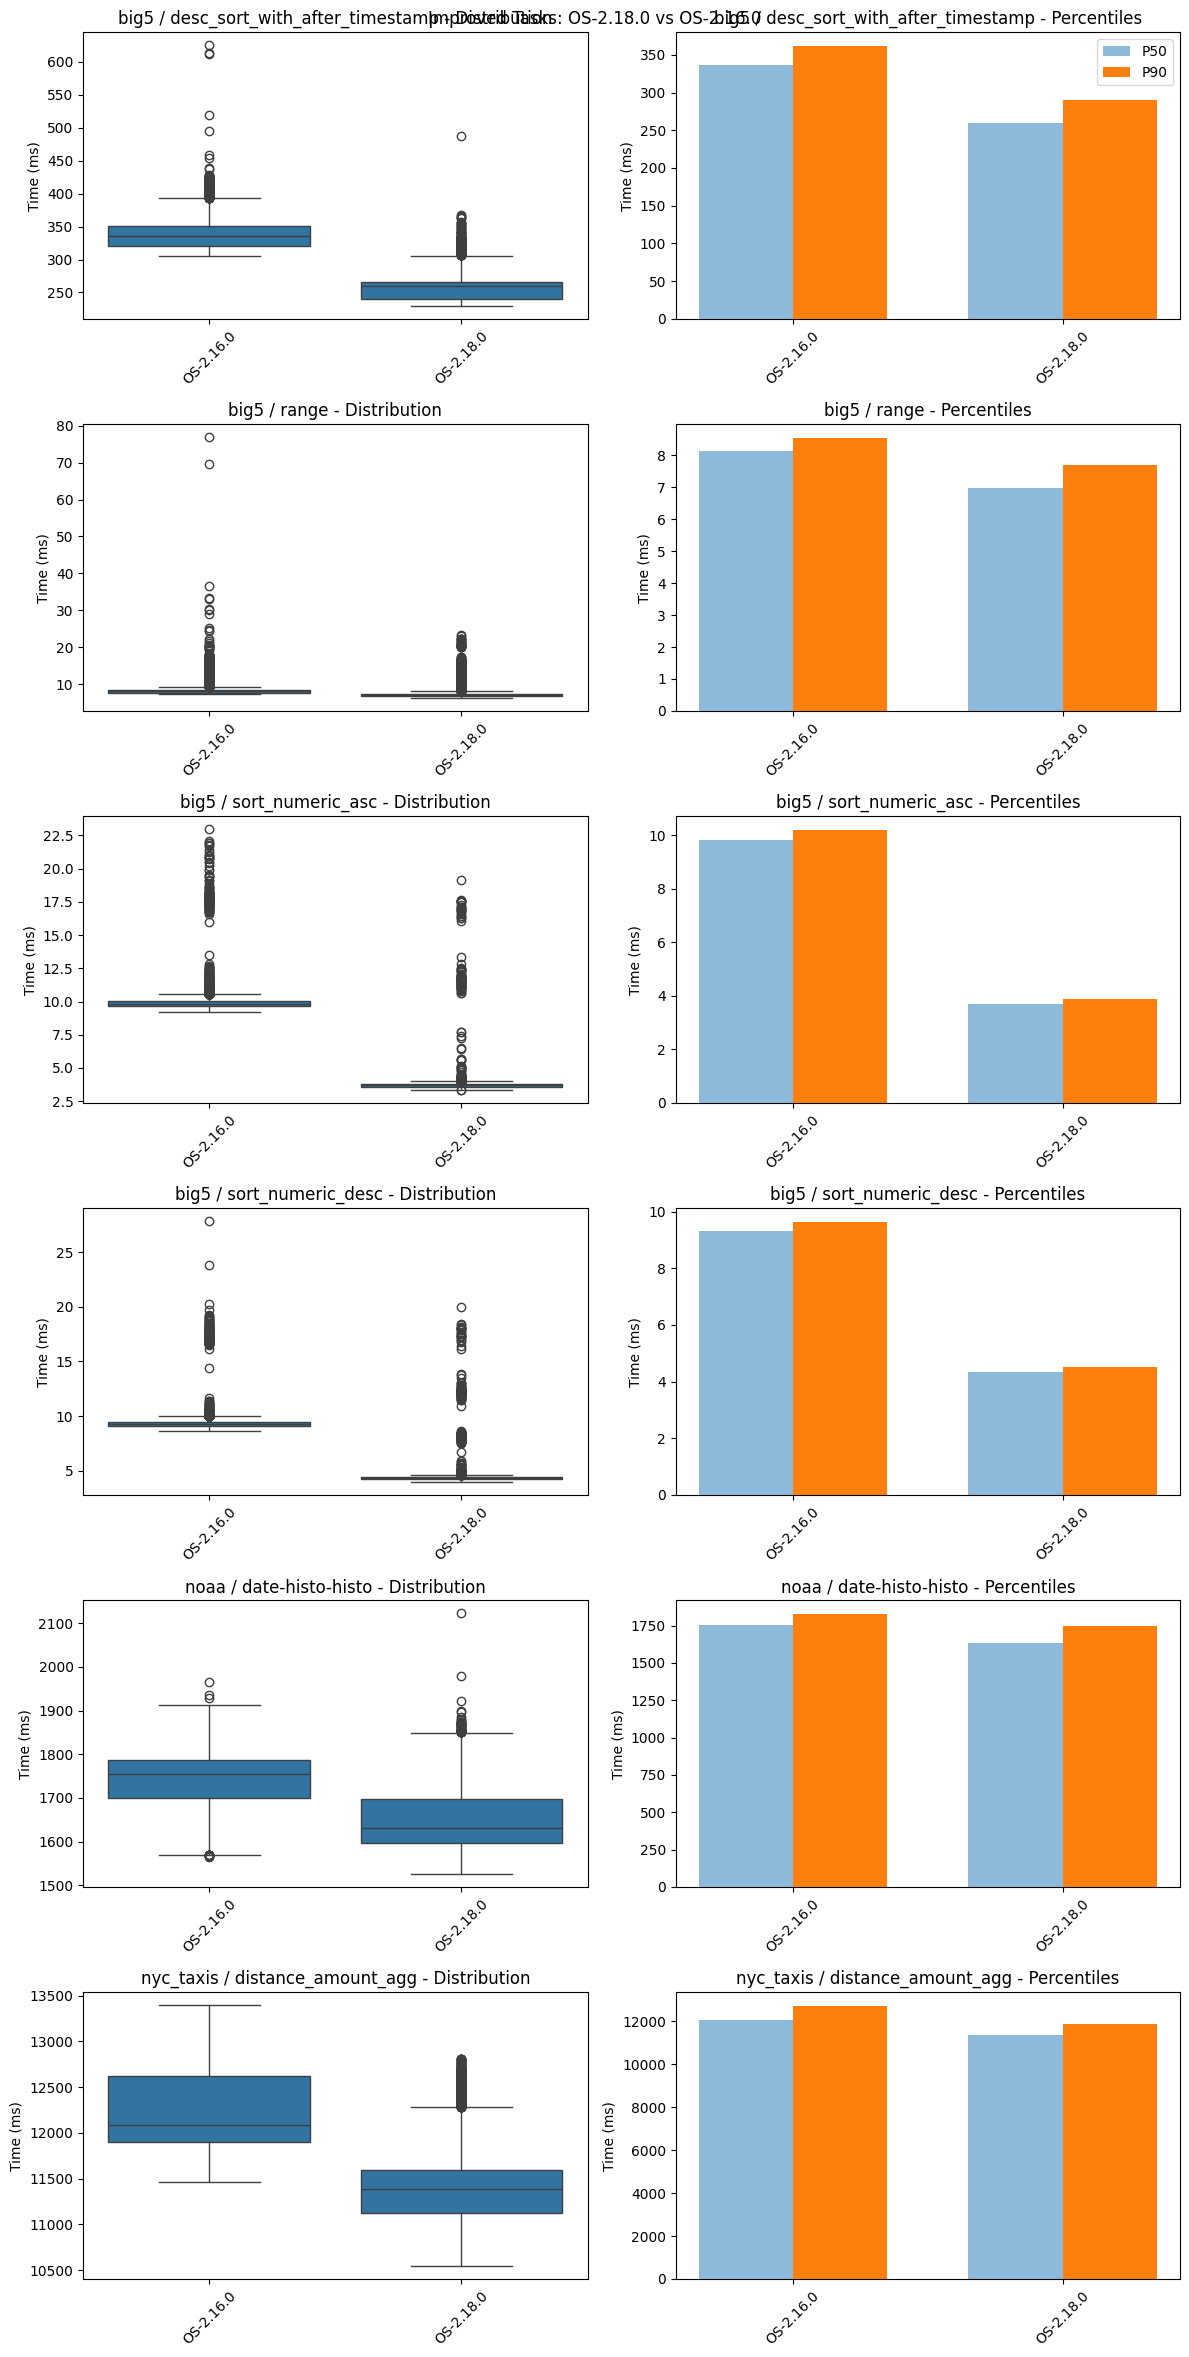

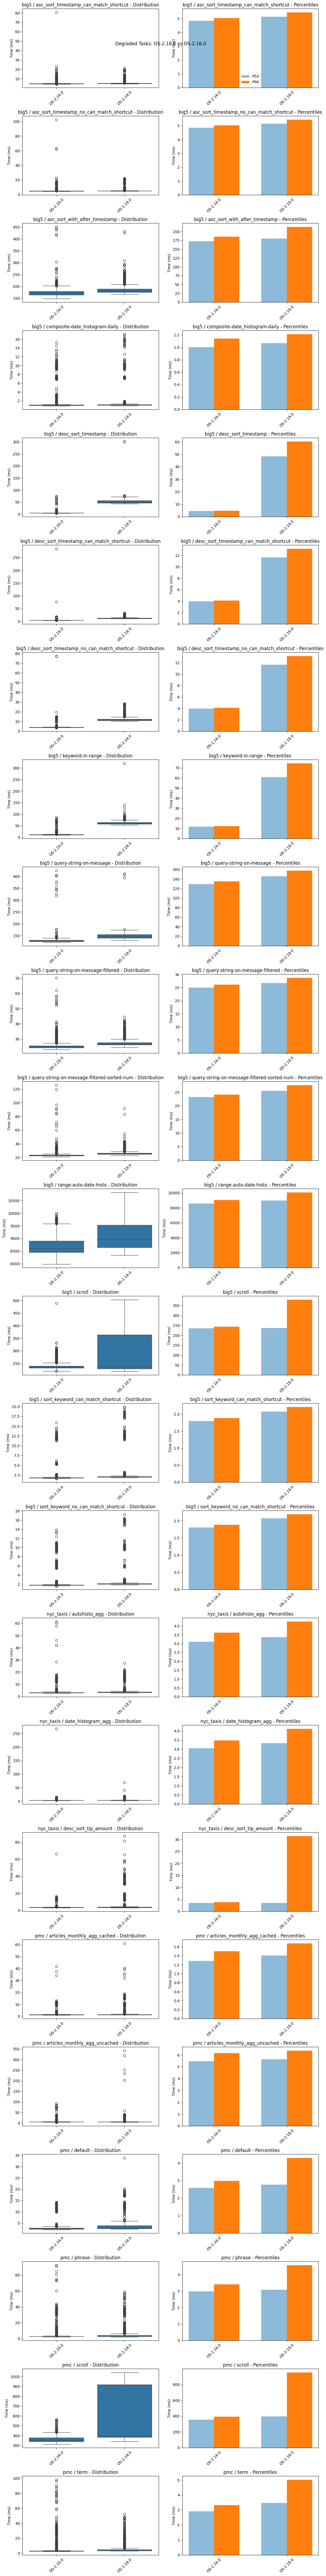

In [178]:
ddf = df.copy()
ddf["task"] = ddf["workload"] + " / " + ddf["operation"]

version1 = "2.16.0"
version2 = "2.18.0"
results = compare_os_versions(ddf, value_field='value', version1=version1, version2=version2)

# Create visualizations
visualize_version_comparison(ddf, results, value_field='value', version1=version1, version2=version2)